In [50]:
import obspy
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from obspy.taup import TauPyModel
%matplotlib inline

In [51]:
model = TauPyModel(model="ak135")

In [52]:
def get_sync(main_path,names,component):
    dirs=[ join(main_path,f"FNET.{name}.MX{component}.sem.sac") for name in names ]
    data=obspy.Stream()
    for item in dirs:
        data+=obspy.read(item)
    return data

In [53]:
def get_data(main_path,names,component):
    dirs=[ join(main_path,f"BO.{name}...{component}") for name in names ]
    data=obspy.Stream()
    for item in dirs:
        data+=obspy.read(item)
    return data    

In [54]:
def preprocess(sync,data,freqmin,freqmax,phase,t1,t2):
    sync.resample(20)
    # trim
    for syncwave,datawave in zip(sync,data):
        starttime=syncwave.stats.starttime+syncwave.stats.sac.o-syncwave.stats.sac.b
        endtime=starttime+1500
        syncwave.trim(starttime,endtime)
        print(starttime)
        starttime=datawave.stats.starttime+datawave.stats.sac.o-datawave.stats.sac.b
        endtime=starttime+1500        
        datawave.trim(starttime,endtime)
        print(starttime)
#     for datawave in data:
#         datawave.trim(datawave.stats.starttime+datawave.stats.sac.o,datawave.stats.endtime)
    
    # detrend
    sync.detrend(type="demean")
    sync.taper(0.05)
#     data.detrend(type="demean")©
#     data.taper(0.05)
    
    # bandpass
    sync.filter("bandpass",freqmin=freqmin,freqmax=freqmax,corners=2,zerophase=False)
    data.filter("bandpass",freqmin=freqmin,freqmax=freqmax,corners=2,zerophase=False)

    print(sync,data)
    # cut according to the phase
    for syncwave,datawave in zip(sync,data):
        syncwave.plot()
        datawave.plot()
        arrivals = model.get_travel_times(source_depth_in_km=syncwave.stats.sac.evdp,distance_in_degree=syncwave.stats.sac.gcarc)
        plot_arrivals=0
        for arrival in arrivals:
            if((arrival.name==phase.upper()) or (arrival.name==phase.lower())):
                plot_arrivals=arrival.time
                break
        phase_arrival_sync=syncwave.stats.starttime+plot_arrivals
        phase_arrival_data=datawave.stats.starttime+plot_arrivals
        
        t1_arrival_sync=phase_arrival_sync+t1
        t2_arrival_sync=phase_arrival_sync+t2
        t1_arrival_data=phase_arrival_data+t1
        t2_arrival_data=phase_arrival_data+t2
        
        syncwave.trim(t1_arrival_sync,t2_arrival_sync)
        datawave.trim(t1_arrival_data,t2_arrival_data)
        
        datawave.data=datawave.data/(1e9)
#         plotx_sync=np.linspace(t1,t2,syncwave.stats.npts) 
#         pltox_data=np.linspace(t1,t2,datawave.stats.npts)
        
#         ploty_sync=syncwave.data
#         ploty_data=datawave.data
    return sync,data

In [55]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
def plot(sync,data,t1,t2,scale):
    plt.figure(figsize=(6,14))
    allstream=obspy.Stream()
    allstream+=sync
    allstream+=data
    allstream.normalize(global_max=False)
    for syncwave,datawave in zip(sync,data):
#         allstream=obspy.Stream()
#         allstream+=syncwave
#         allstream+=datawave
#         allstream.normalize(global_max=True)
        
        plotx_sync=np.linspace(t1,t2,syncwave.stats.npts)-t1 
        plotx_data=np.linspace(t1,t2,datawave.stats.npts)-t1
        
        ploty_sync=syncwave.data*scale+syncwave.stats.sac.gcarc
        ploty_data=datawave.data*scale+syncwave.stats.sac.gcarc
        
        plt.plot(plotx_sync,ploty_sync,color="r")
        plt.plot(plotx_data,ploty_data,color="k")
        
        plt.text(t2-t1+10,syncwave.stats.sac.gcarc,datawave.id[:-2],fontsize=20)
    plt.xticks(np.arange(0,t2-t1+10,20))
    plt.xlabel("Time(s)", fontsize=20)
    plt.ylabel("Dist(deg)", fontsize=20)
    plt.text(70,13.7,"SH(10s-100s)",fontsize=20)
    plt.show()

In [56]:
# names=["KNY","FUJ","NAA","TTO","KNM","SRN","WJM"]
names=["KIS","NOK","ABU","YZK","SAG","ISI","NRW","YSI"]

In [57]:
# sync=get_sync("/Users/ziyixi/Datas/fnet/taokaifig15_sync/taokaifig15",names,"Z")
sync=get_sync("/Users/ziyixi/Datas/fnet/201608041624382_sync_tao",names,"Z")
# sync=get_sync("/Users/ziyixi/Datas/fnet/201201010528014_tao_sync",names,"Z")
# sync=get_sync("/Users/ziyixi/Datas/fnet/201208080711021_sync",names,"Z")
# sync=get_sync("/Users/ziyixi/Datas/fnet/201311222204260_tao_sync",names,"Z")

In [58]:
sync

8 Trace(s) in Stream:
FNET.KIS.S3.MXZ | 2016-08-04T16:24:33.239000Z - 2016-08-04T17:09:44.369578Z | 9.2 Hz, 24900 samples
FNET.NOK.S3.MXZ | 2016-08-04T16:24:33.239000Z - 2016-08-04T17:09:44.369578Z | 9.2 Hz, 24900 samples
FNET.ABU.S3.MXZ | 2016-08-04T16:24:33.239000Z - 2016-08-04T17:09:44.369578Z | 9.2 Hz, 24900 samples
FNET.YZK.S3.MXZ | 2016-08-04T16:24:33.239000Z - 2016-08-04T17:09:44.369578Z | 9.2 Hz, 24900 samples
FNET.SAG.S3.MXZ | 2016-08-04T16:24:33.239000Z - 2016-08-04T17:09:44.369578Z | 9.2 Hz, 24900 samples
FNET.ISI.S3.MXZ | 2016-08-04T16:24:33.239000Z - 2016-08-04T17:09:44.369578Z | 9.2 Hz, 24900 samples
FNET.NRW.S3.MXZ | 2016-08-04T16:24:33.239000Z - 2016-08-04T17:09:44.369578Z | 9.2 Hz, 24900 samples
FNET.YSI.S3.MXZ | 2016-08-04T16:24:33.239000Z - 2016-08-04T17:09:44.369578Z | 9.2 Hz, 24900 samples

In [59]:
# data=get_data("/Users/ziyixi/Datas/fnet/201105101526A",names,"Z")
data=get_data("/Users/ziyixi/Datas/fnet/201608041624A",names,"Z")
# data=get_data("/Users/ziyixi/Datas/fnet/201201010527A",names,"Z")
# data=get_data("/Users/ziyixi/Datas/fnet/201208080711A",names,"Z")
# data=get_data("/Users/ziyixi/Datas/fnet/201311222204A",names,"Z")

In [60]:
data

8 Trace(s) in Stream:
BO.KIS..BHZ | 2016-08-04T16:22:37.999998Z - 2016-08-04T17:04:37.949998Z | 20.0 Hz, 50400 samples
BO.NOK..BHZ | 2016-08-04T16:22:37.999998Z - 2016-08-04T17:04:37.949998Z | 20.0 Hz, 50400 samples
BO.ABU..BHZ | 2016-08-04T16:22:37.999998Z - 2016-08-04T17:04:37.949998Z | 20.0 Hz, 50400 samples
BO.YZK..BHZ | 2016-08-04T16:22:37.999998Z - 2016-08-04T17:04:37.949998Z | 20.0 Hz, 50400 samples
BO.SAG..BHZ | 2016-08-04T16:22:37.999998Z - 2016-08-04T17:04:37.949998Z | 20.0 Hz, 50400 samples
BO.ISI..BHZ | 2016-08-04T16:22:37.999998Z - 2016-08-04T17:04:37.949998Z | 20.0 Hz, 50400 samples
BO.NRW..BHZ | 2016-08-04T16:22:37.999998Z - 2016-08-04T17:04:37.949998Z | 20.0 Hz, 50400 samples
BO.YSI..BHZ | 2016-08-04T16:22:37.999998Z - 2016-08-04T17:04:37.949998Z | 20.0 Hz, 50400 samples

2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
8 Trace(s) in Stream:
FNET.KIS.S3.MXZ | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.NOK.S3.MXZ | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.ABU.S3.MXZ | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.YZK.S3.MXZ | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.SAG.S3.MXZ | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.ISI.S3.MXZ | 2016-08

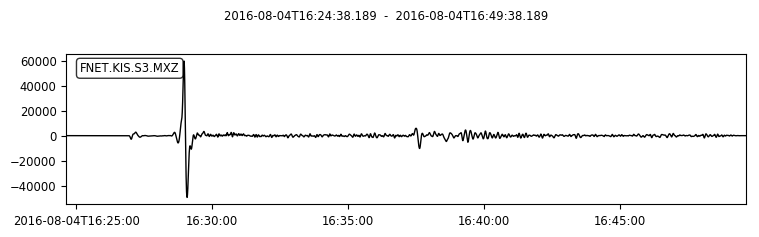

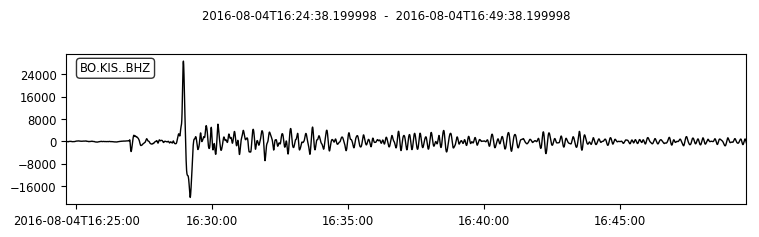

/Users/ziyixi/backup/obspy/obspy/taup/tau_branch.py:495: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


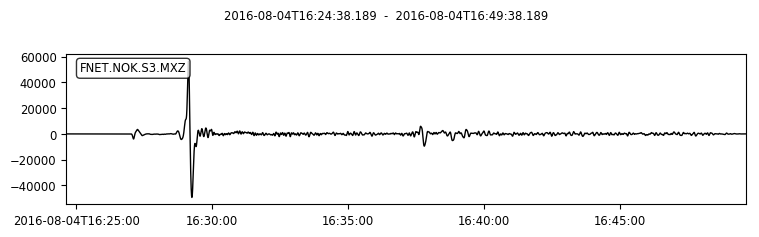

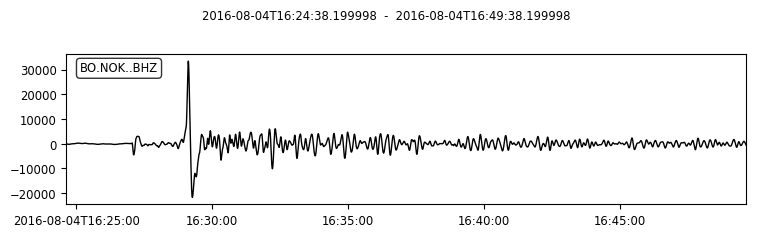

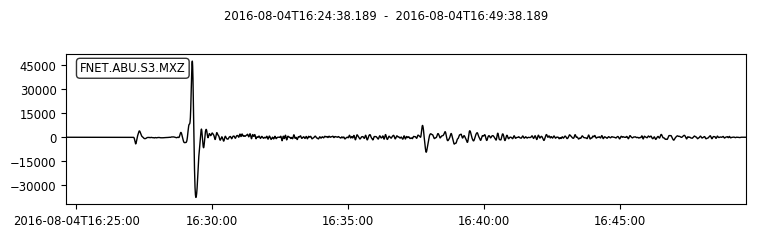

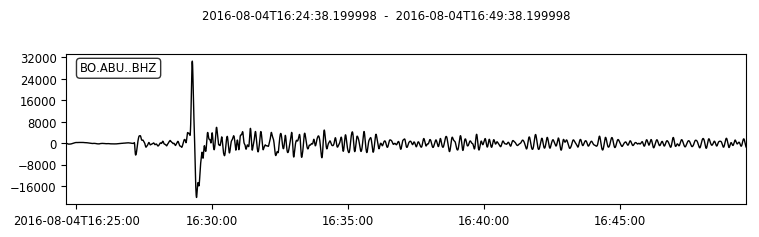

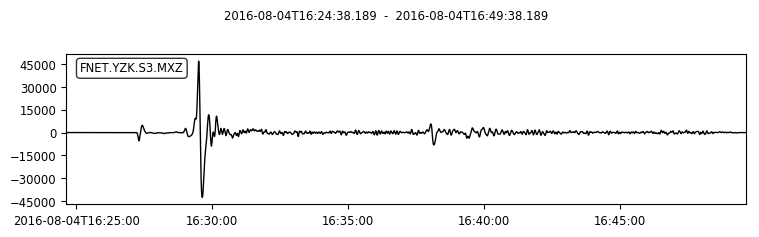

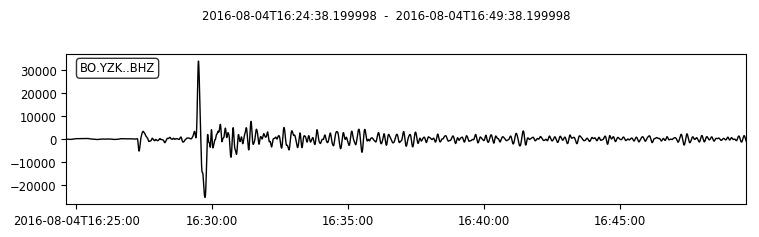

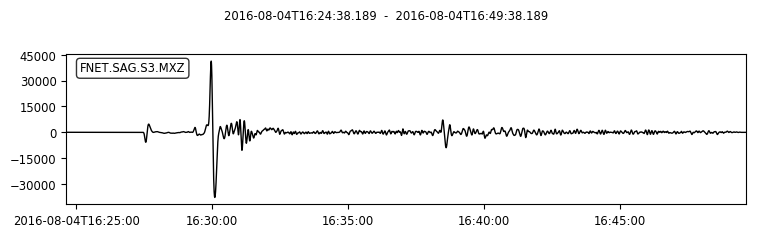

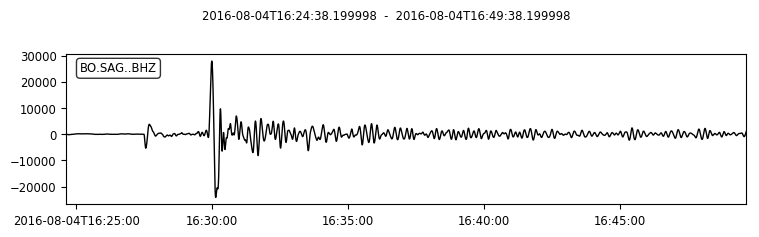

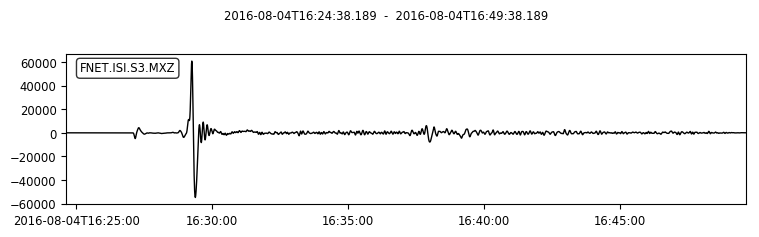

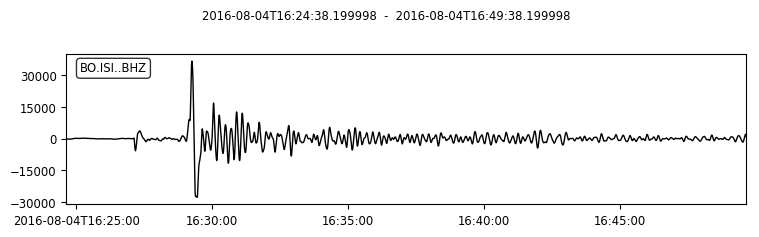

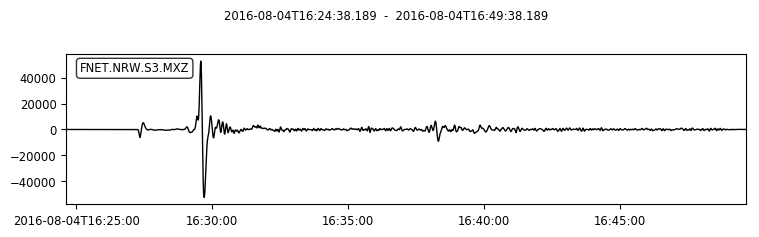

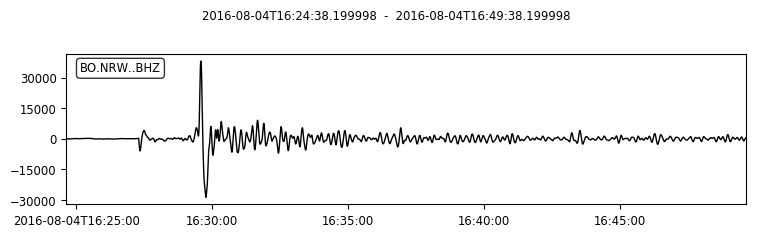

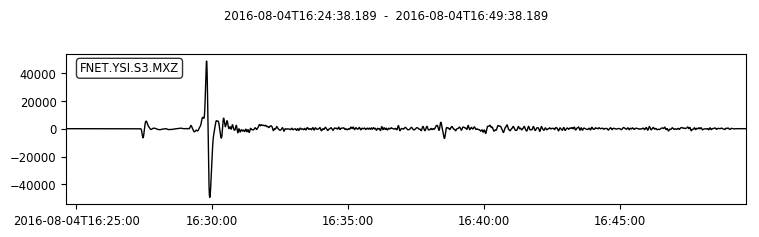

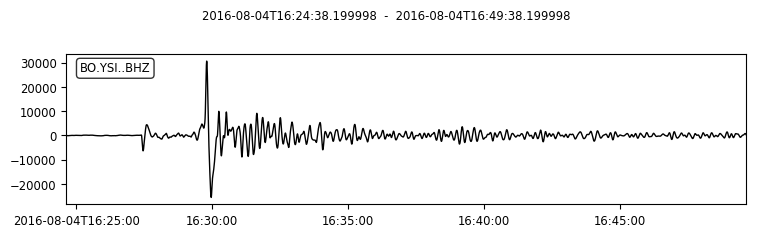

(8 Trace(s) in Stream:
FNET.KIS.S3.MXZ | 2016-08-04T16:28:04.339000Z - 2016-08-04T16:30:04.339000Z | 20.0 Hz, 2401 samples
FNET.NOK.S3.MXZ | 2016-08-04T16:28:13.889000Z - 2016-08-04T16:30:13.889000Z | 20.0 Hz, 2401 samples
FNET.ABU.S3.MXZ | 2016-08-04T16:28:23.289000Z - 2016-08-04T16:30:23.289000Z | 20.0 Hz, 2401 samples
FNET.YZK.S3.MXZ | 2016-08-04T16:28:36.389000Z - 2016-08-04T16:30:36.389000Z | 20.0 Hz, 2401 samples
FNET.SAG.S3.MXZ | 2016-08-04T16:29:04.939000Z - 2016-08-04T16:31:04.939000Z | 20.0 Hz, 2401 samples
FNET.ISI.S3.MXZ | 2016-08-04T16:28:20.489000Z - 2016-08-04T16:30:20.489000Z | 20.0 Hz, 2401 samples
FNET.NRW.S3.MXZ | 2016-08-04T16:28:40.189000Z - 2016-08-04T16:30:40.189000Z | 20.0 Hz, 2401 samples
FNET.YSI.S3.MXZ | 2016-08-04T16:28:52.939000Z - 2016-08-04T16:30:52.939000Z | 20.0 Hz, 2401 samples,
 8 Trace(s) in Stream:
BO.KIS..BHZ | 2016-08-04T16:28:04.349998Z - 2016-08-04T16:30:04.349998Z | 20.0 Hz, 2401 samples
BO.NOK..BHZ | 2016-08-04T16:28:13.899998Z - 2016-08-04T16

In [61]:
preprocess(sync,data,1/100,1/10,"s",-50,70)

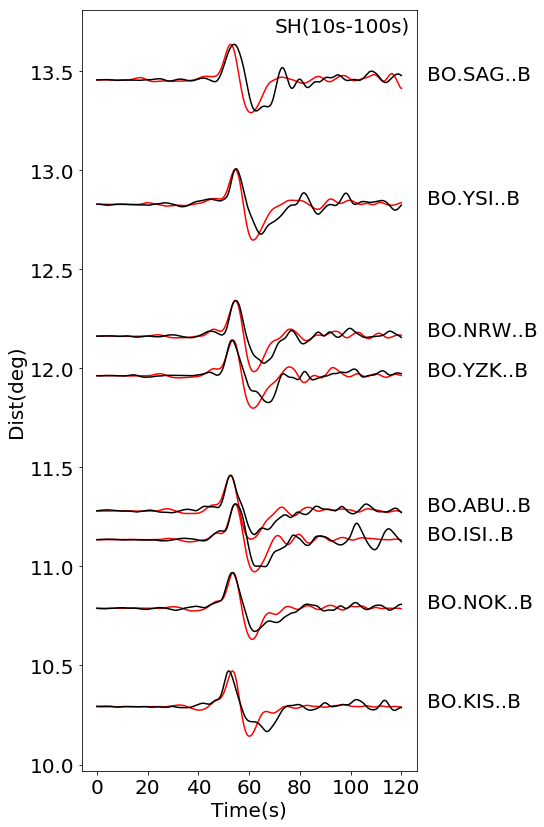

In [1904]:
plot(sync,data,-50,70,0.18)

In [65]:
def plot_three_component(dataz,datar,datat,syncz,syncr,synct,t1,t2,scale):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14,8))
    
    sync=syncz
    data=dataz
    ax1 = axes[0]
    
    allstream=obspy.Stream()
    allstream+=sync
    allstream+=data
    allstream.normalize(global_max=False)
    for syncwave,datawave in zip(sync,data):
        plotx_sync=np.linspace(t1,t2,syncwave.stats.npts)-t1 
        plotx_data=np.linspace(t1,t2,datawave.stats.npts)-t1
        
        ploty_sync=syncwave.data*scale+syncwave.stats.sac.gcarc
        ploty_data=datawave.data*scale+syncwave.stats.sac.gcarc
        
        ax1.plot(plotx_sync,ploty_sync,color="r")
        ax1.plot(plotx_data,ploty_data,color="k")
        
#         plt.text(t2-t1+10,syncwave.stats.sac.gcarc,datawave.id[:-2],fontsize=20)
    ax1.set_xticks(np.arange(0,t2-t1+10,20))
    ax1.set_xlabel("Time(s)", fontsize=20)
    ax1.set_ylabel("Dist(deg)", fontsize=20)
    ax1.text(22,13.68,"BHZ SV(10s-100s)",fontsize=20)

    sync=syncr
    data=datar
    ax2=axes[1]
    
    allstream=obspy.Stream()
    allstream+=sync
    allstream+=data
    allstream.normalize(global_max=False)
    for syncwave,datawave in zip(sync,data):
        plotx_sync=np.linspace(t1,t2,syncwave.stats.npts)-t1 
        plotx_data=np.linspace(t1,t2,datawave.stats.npts)-t1
        
        ploty_sync=syncwave.data*scale+syncwave.stats.sac.gcarc
        ploty_data=datawave.data*scale+syncwave.stats.sac.gcarc
        
        ax2.plot(plotx_sync,ploty_sync,color="r")
        ax2.plot(plotx_data,ploty_data,color="k")
        
#         plt.text(t2-t1+10,syncwave.stats.sac.gcarc,datawave.id[:-2],fontsize=20)
    ax2.set_xticks(np.arange(0,t2-t1+10,20))
    ax2.set_xlabel("Time(s)", fontsize=20)
#     ax1.set_ylabel("Dist(deg)", fontsize=20)
    ax2.text(22,13.68,"BHR SV(10s-100s)",fontsize=20)
    
    
    sync=synct
    data=datat
    ax3=axes[2]
    
    allstream=obspy.Stream()
    allstream+=sync
    allstream+=data
    allstream.normalize(global_max=False)
    for syncwave,datawave in zip(sync,data):
        plotx_sync=np.linspace(t1,t2,syncwave.stats.npts)-t1 
        plotx_data=np.linspace(t1,t2,datawave.stats.npts)-t1
        
        ploty_sync=syncwave.data*scale+syncwave.stats.sac.gcarc
        ploty_data=datawave.data*scale+syncwave.stats.sac.gcarc
        
        ax3.plot(plotx_sync,ploty_sync,color="r")
        ax3.plot(plotx_data,ploty_data,color="k")
        
        plt.text(t2-t1+10,syncwave.stats.sac.gcarc,datawave.id[:-2],fontsize=20)
    ax3.set_xticks(np.arange(0,t2-t1+10,20))
    ax3.set_xlabel("Time(s)", fontsize=20)
#     ax1.set_ylabel("Dist(deg)", fontsize=20)
    ax3.text(22,13.68,"BHT SH(10s-100s)",fontsize=20)
    
#     plt.show()
    plt.savefig("./local.eps")

2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
8 Trace(s) in Stream:
FNET.KIS.S3.MXZ | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.NOK.S3.MXZ | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.ABU.S3.MXZ | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.YZK.S3.MXZ | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.SAG.S3.MXZ | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.ISI.S3.MXZ | 2016-08

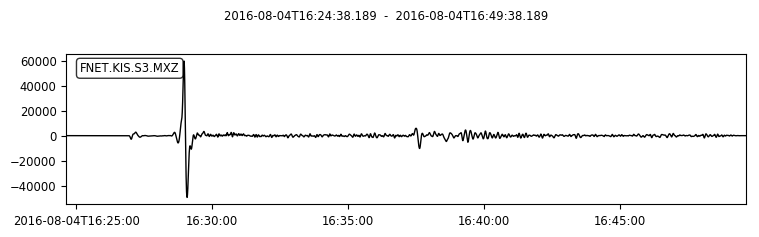

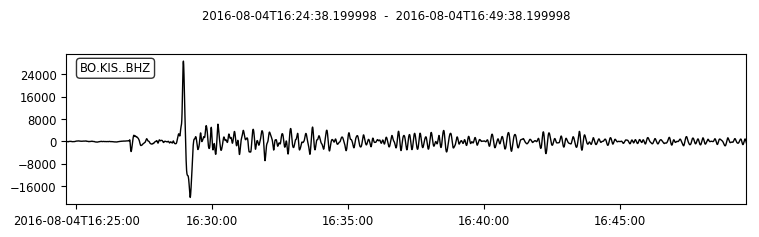

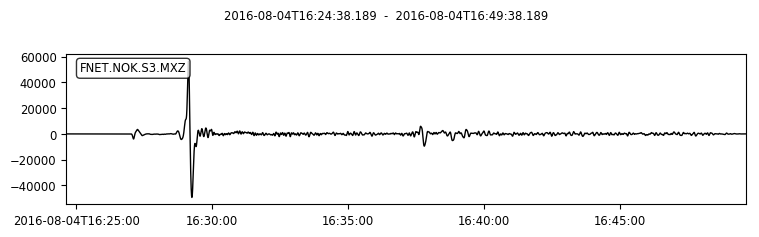

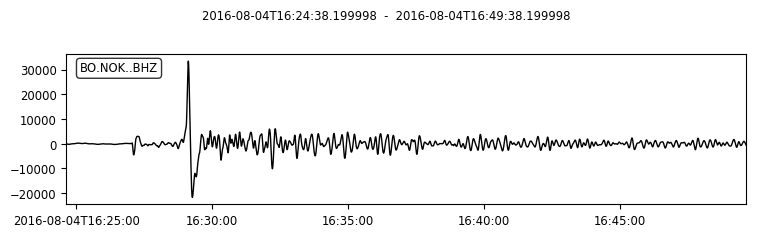

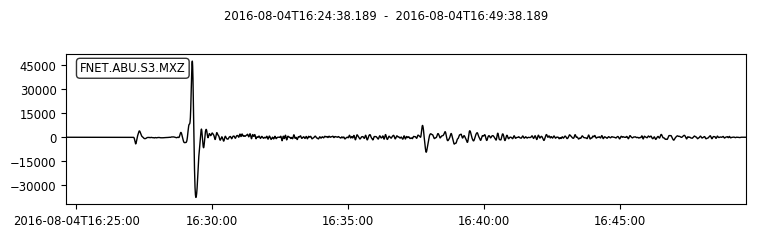

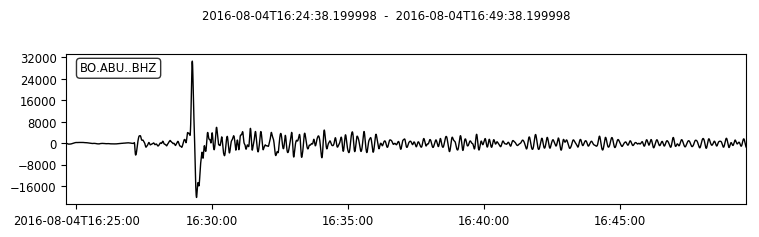

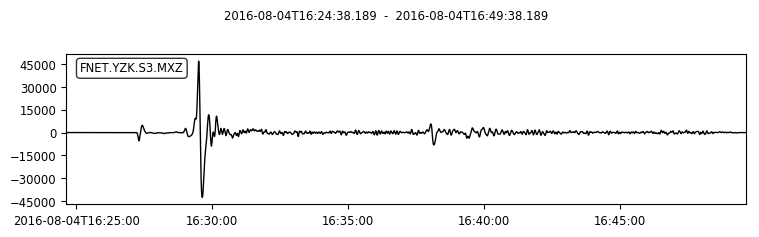

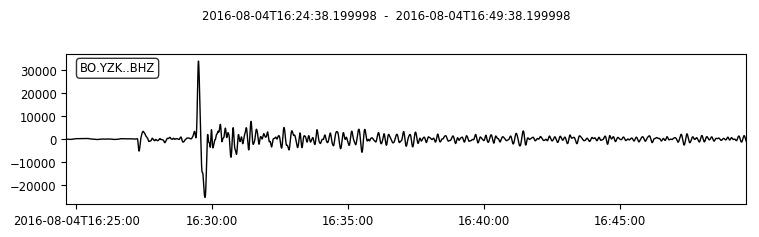

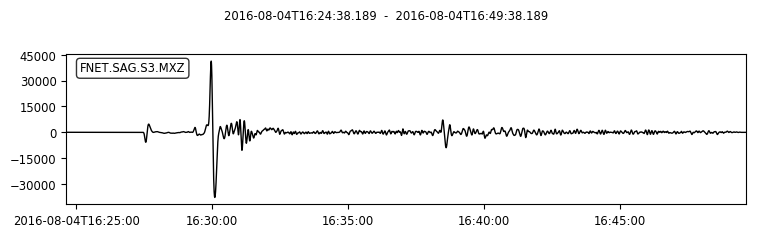

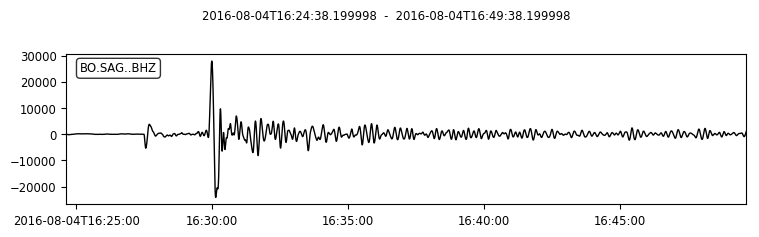

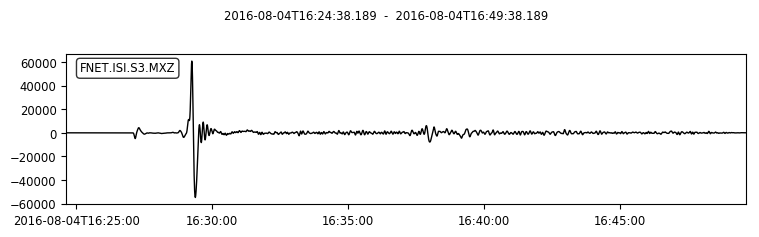

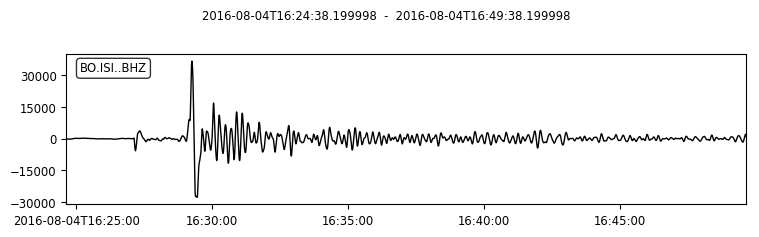

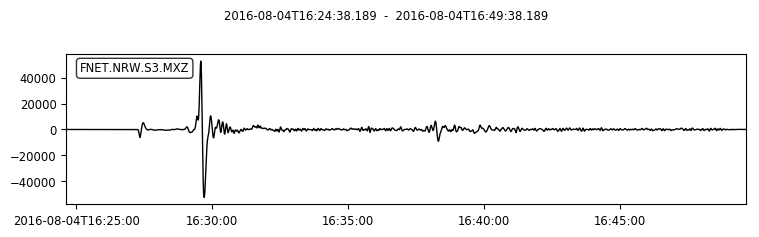

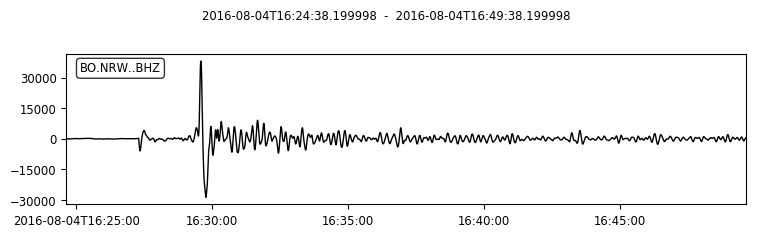

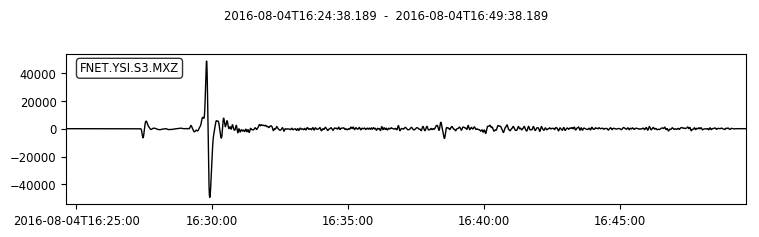

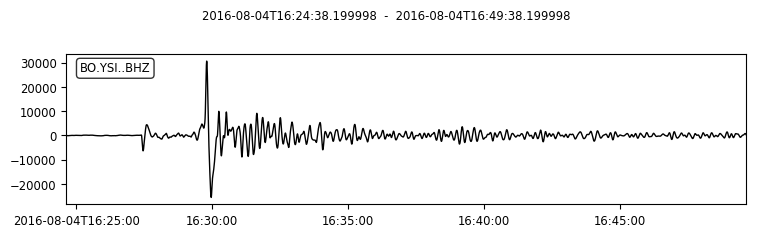

2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
8 Trace(s) in Stream:
FNET.KIS.S3.MXR | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.NOK.S3.MXR | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.ABU.S3.MXR | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.YZK.S3.MXR | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.SAG.S3.MXR | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.ISI.S3.MXR | 2016-08

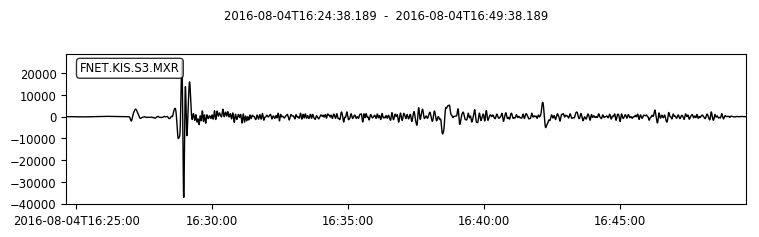

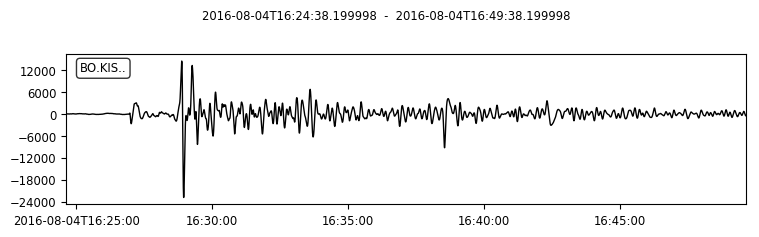

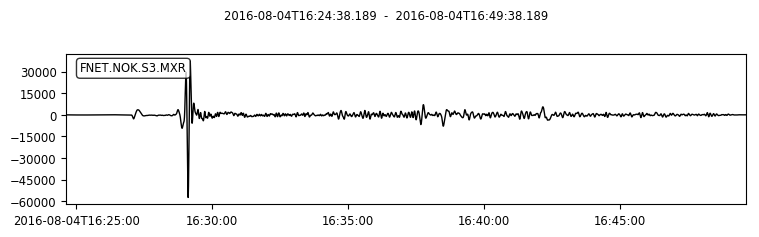

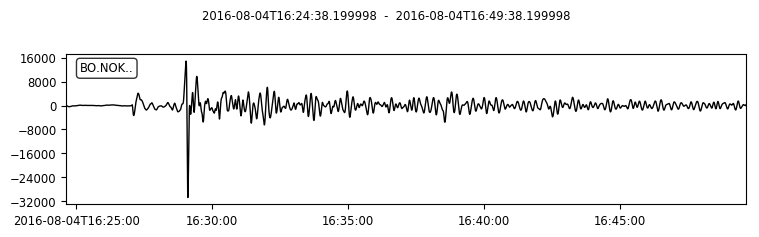

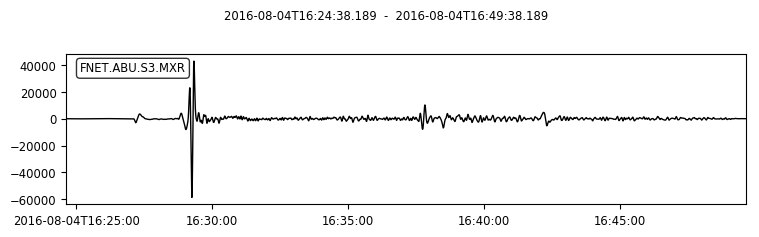

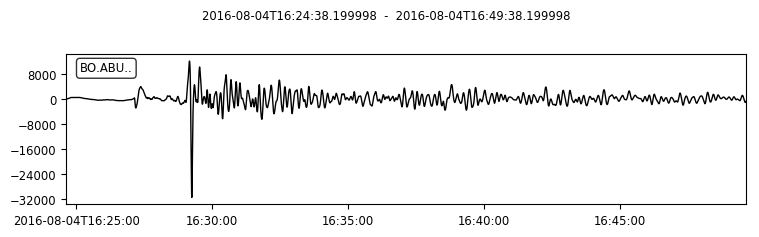

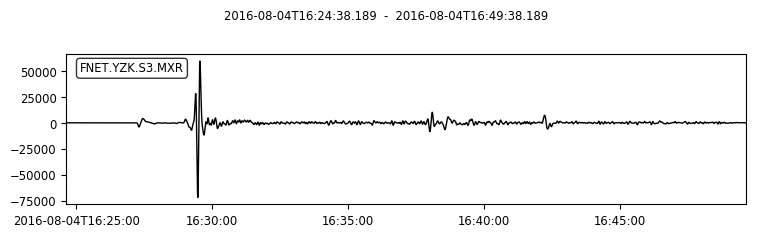

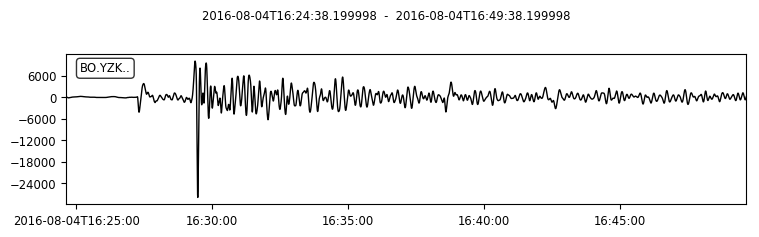

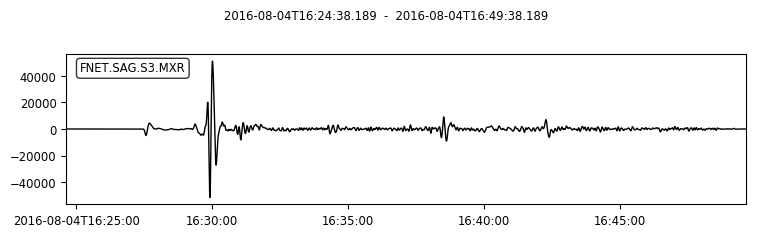

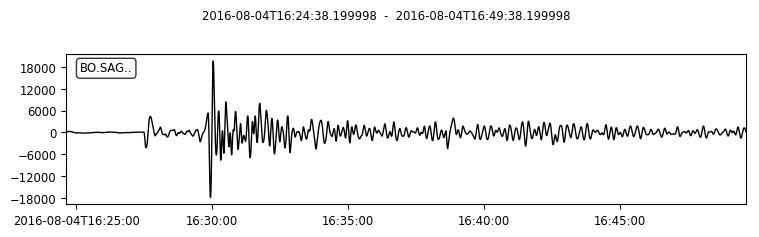

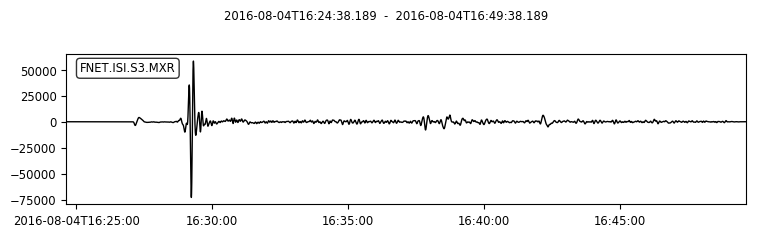

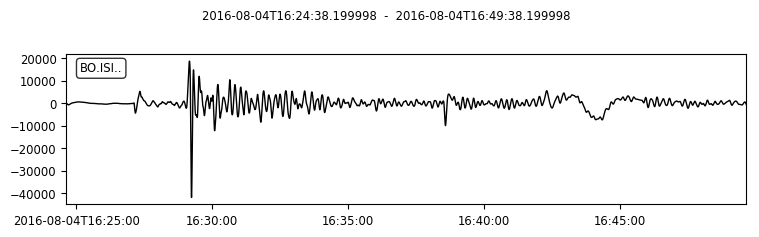

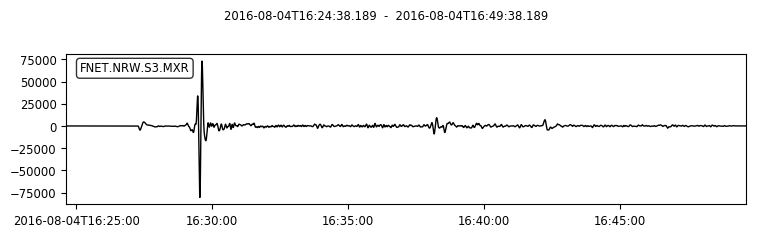

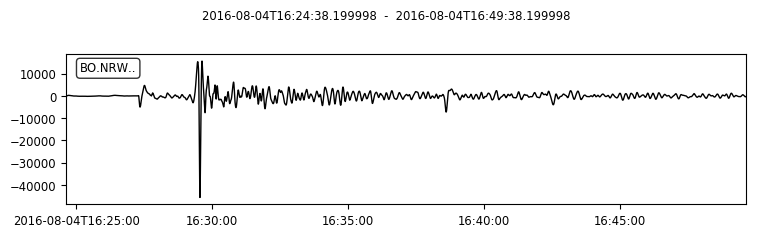

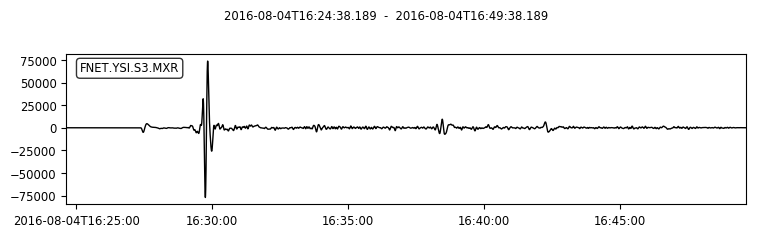

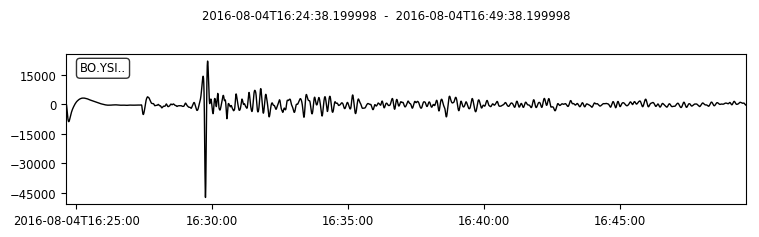

2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.190000Z
8 Trace(s) in Stream:
FNET.KIS.S3.MXT | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.NOK.S3.MXT | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.ABU.S3.MXT | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.YZK.S3.MXT | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.SAG.S3.MXT | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
FNET.ISI.S3.MXT | 2016-08

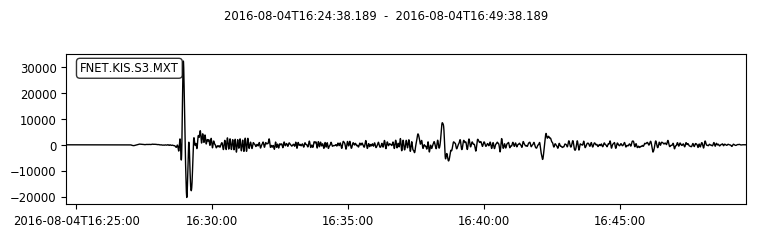

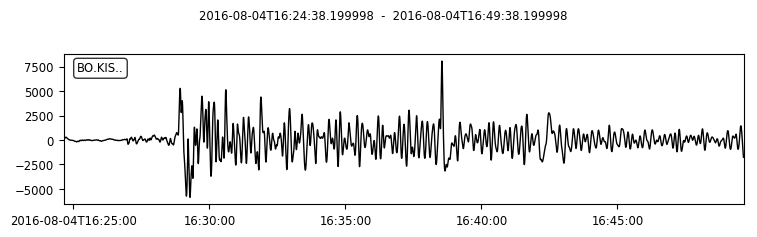

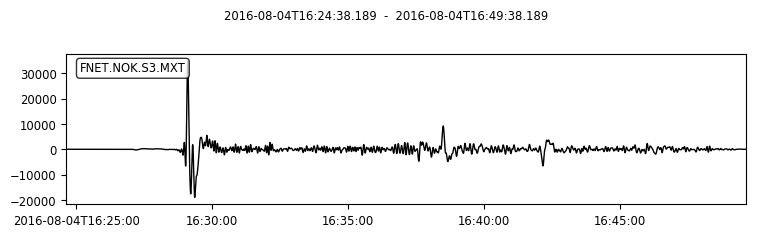

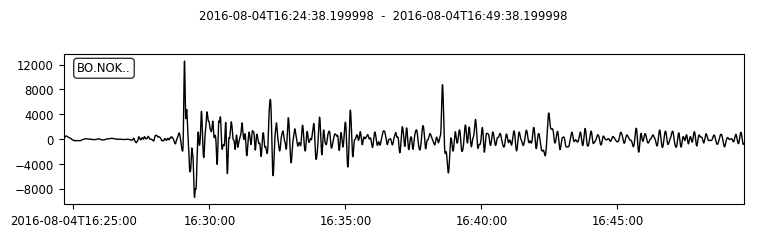

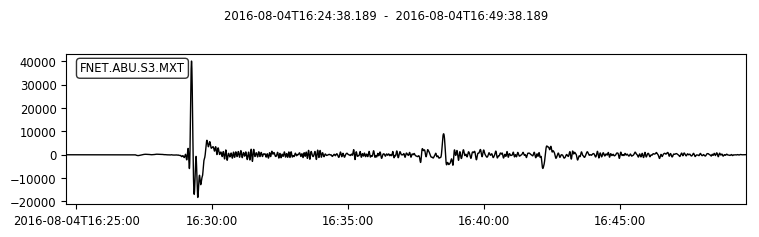

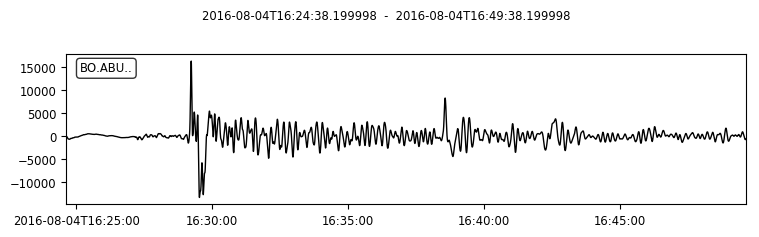

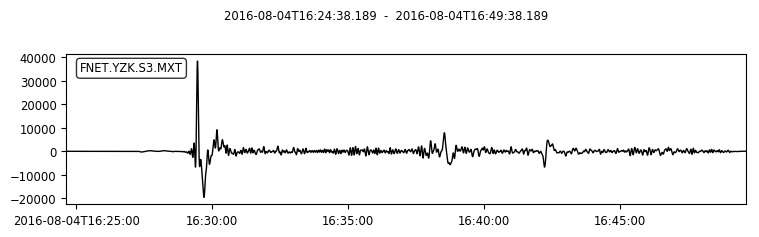

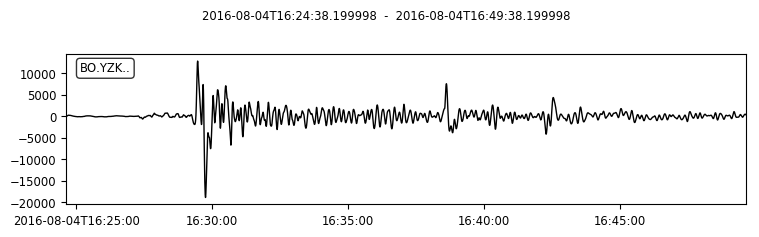

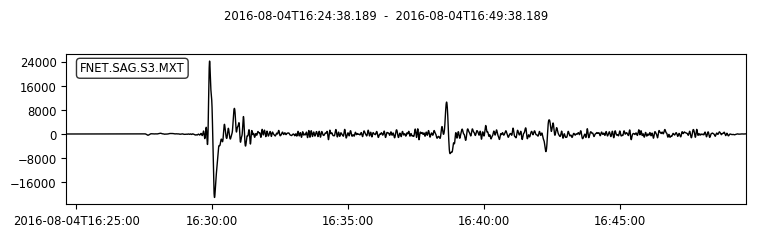

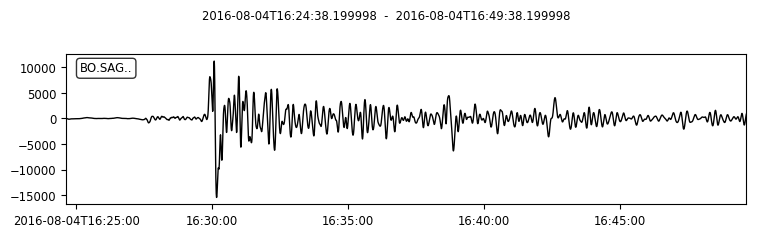

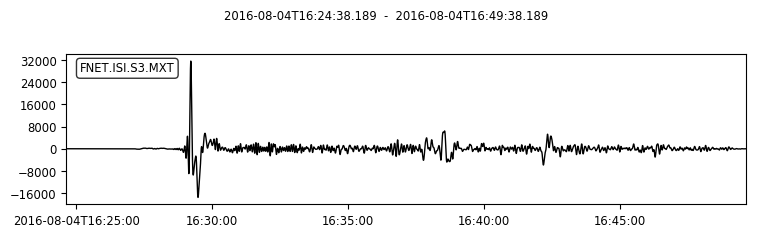

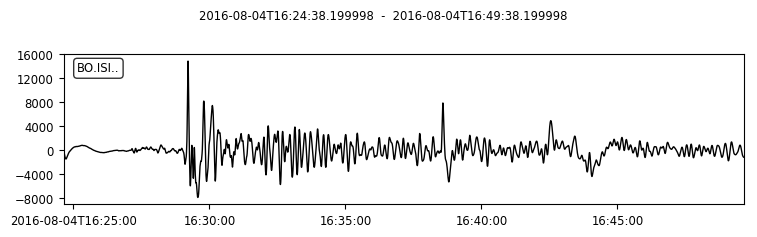

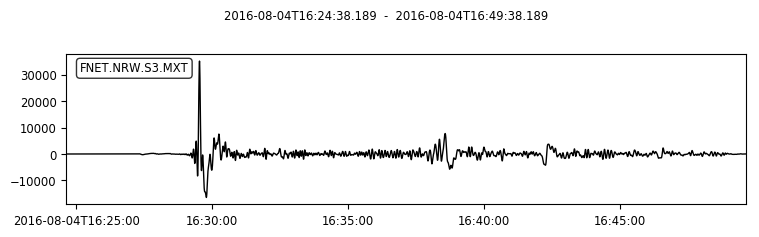

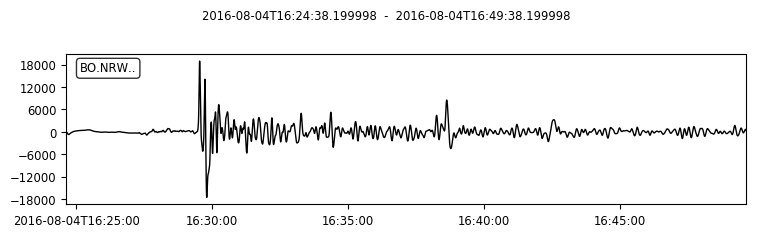

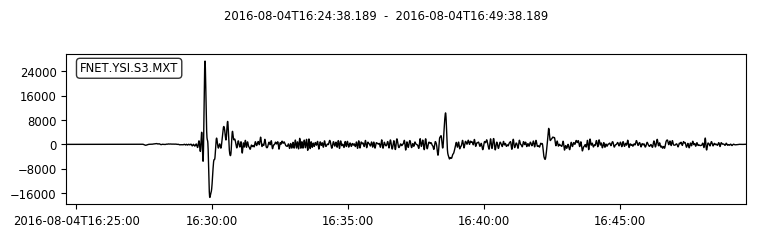

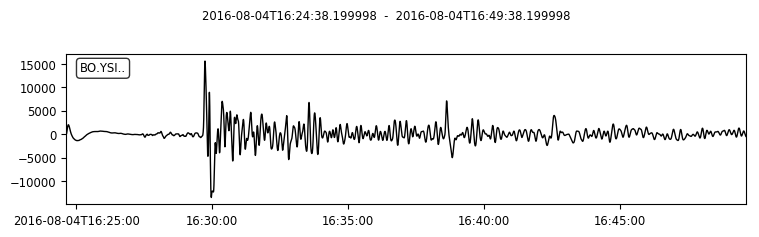

(8 Trace(s) in Stream:
FNET.KIS.S3.MXT | 2016-08-04T16:28:04.339000Z - 2016-08-04T16:30:04.339000Z | 20.0 Hz, 2401 samples
FNET.NOK.S3.MXT | 2016-08-04T16:28:13.889000Z - 2016-08-04T16:30:13.889000Z | 20.0 Hz, 2401 samples
FNET.ABU.S3.MXT | 2016-08-04T16:28:23.289000Z - 2016-08-04T16:30:23.289000Z | 20.0 Hz, 2401 samples
FNET.YZK.S3.MXT | 2016-08-04T16:28:36.389000Z - 2016-08-04T16:30:36.389000Z | 20.0 Hz, 2401 samples
FNET.SAG.S3.MXT | 2016-08-04T16:29:04.939000Z - 2016-08-04T16:31:04.939000Z | 20.0 Hz, 2401 samples
FNET.ISI.S3.MXT | 2016-08-04T16:28:20.489000Z - 2016-08-04T16:30:20.489000Z | 20.0 Hz, 2401 samples
FNET.NRW.S3.MXT | 2016-08-04T16:28:40.189000Z - 2016-08-04T16:30:40.189000Z | 20.0 Hz, 2401 samples
FNET.YSI.S3.MXT | 2016-08-04T16:28:52.939000Z - 2016-08-04T16:30:52.939000Z | 20.0 Hz, 2401 samples,
 8 Trace(s) in Stream:
BO.KIS.. | 2016-08-04T16:28:04.349998Z - 2016-08-04T16:30:04.349998Z | 20.0 Hz, 2401 samples
BO.NOK.. | 2016-08-04T16:28:13.899998Z - 2016-08-04T16:30:13

In [66]:
syncz=get_sync("/Users/ziyixi/Datas/fnet/201608041624382_sync_tao",names,"Z")
dataz=get_data("/Users/ziyixi/Datas/fnet/201608041624A",names,"Z")
syncr=get_sync("/Users/ziyixi/Datas/fnet/201608041624382_sync_tao",names,"R")
datar=get_data("/Users/ziyixi/Datas/fnet/201608041624A",names,"R")
synct=get_sync("/Users/ziyixi/Datas/fnet/201608041624382_sync_tao",names,"T")
datat=get_data("/Users/ziyixi/Datas/fnet/201608041624A",names,"T")
preprocess(syncz,dataz,1/100,1/10,"s",-50,70)
preprocess(syncr,datar,1/100,1/10,"s",-50,70)
preprocess(synct,datat,1/100,1/10,"s",-50,70)

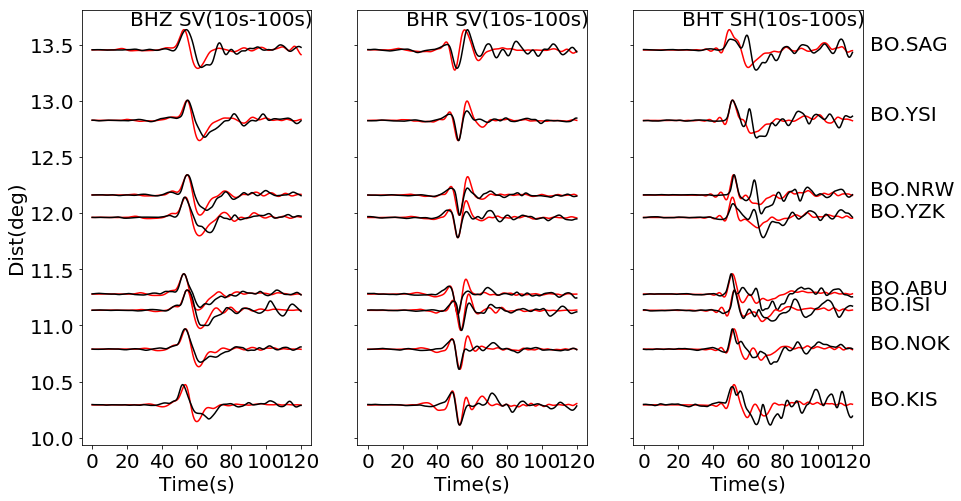

In [67]:
plot_three_component(dataz,datar,datat,syncz,syncr,synct,-50,70,0.18)

In [15]:
def get_data_cea(main_path,names,component):
    dirs=[ join(main_path,f"*.{name}.00..{component}") for name in names ]
    data=obspy.Stream()
    for item in dirs:
        data+=obspy.read(item)
    return data   

def get_sync_cea(main_path,names,component):
    dirs=[ join(main_path,f"*.{name}.MX{component}.sem.sac") for name in names ]
    data=obspy.Stream()
    for item in dirs:
        data+=obspy.read(item)
    return data

In [82]:
def plot_three_component_cea(dataz,datar,datat,syncz,syncr,synct,t1,t2,scale):
#     fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14,8))
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14,14))
    
    sync=syncz
    data=dataz
    ax1 = axes[0]
    
    allstream=obspy.Stream()
    allstream+=sync
    allstream+=data
    allstream.normalize(global_max=False)
    for syncwave,datawave in zip(sync,data):
        plotx_sync=np.linspace(t1,t2,syncwave.stats.npts)-t1 
        plotx_data=np.linspace(t1,t2,datawave.stats.npts)-t1
        
        ploty_sync=syncwave.data*scale+syncwave.stats.sac.gcarc
        ploty_data=datawave.data*scale+syncwave.stats.sac.gcarc
        
        ax1.plot(plotx_sync,ploty_sync,color="r")
        ax1.plot(plotx_data,ploty_data,color="k")
        
#         plt.text(t2-t1+10,syncwave.stats.sac.gcarc,datawave.id[:-2],fontsize=20)
    ax1.set_xticks(np.arange(0,t2-t1+10,20))
    ax1.set_xlabel("Time(s)", fontsize=20)
    ax1.set_ylabel("Dist(deg)", fontsize=20)
#     ax1.set_ylim([20.3,23.5])
#     ax1.text(22,23.38,"BHZ SV(10s-100s)",fontsize=20)

    sync=syncr
    data=datar
    ax2=axes[1]
    
    allstream=obspy.Stream()
    allstream+=sync
    allstream+=data
    allstream.normalize(global_max=False)
    for syncwave,datawave in zip(sync,data):
        plotx_sync=np.linspace(t1,t2,syncwave.stats.npts)-t1 
        plotx_data=np.linspace(t1,t2,datawave.stats.npts)-t1
        
        ploty_sync=syncwave.data*scale+syncwave.stats.sac.gcarc
        ploty_data=datawave.data*scale+syncwave.stats.sac.gcarc
        
        ax2.plot(plotx_sync,ploty_sync,color="r")
        ax2.plot(plotx_data,ploty_data,color="k")
        
#         plt.text(t2-t1+10,syncwave.stats.sac.gcarc,datawave.id[:-2],fontsize=20)
    ax2.set_xticks(np.arange(0,t2-t1+10,20))
    ax2.set_xlabel("Time(s)", fontsize=20)
#     ax1.set_ylabel("Dist(deg)", fontsize=20)
#     ax2.text(22,23.38,"BHR SV(10s-100s)",fontsize=20)
#     ax2.set_ylim([20.3,23.5])
    
    
    sync=synct
    data=datat
    ax3=axes[2]
    
    allstream=obspy.Stream()
    allstream+=sync
    allstream+=data
    allstream.normalize(global_max=False)
    for syncwave,datawave in zip(sync,data):
        plotx_sync=np.linspace(t1,t2,syncwave.stats.npts)-t1 
        plotx_data=np.linspace(t1,t2,datawave.stats.npts)-t1
        
        ploty_sync=syncwave.data*scale+syncwave.stats.sac.gcarc
        ploty_data=datawave.data*scale+syncwave.stats.sac.gcarc
        
        ax3.plot(plotx_sync,ploty_sync,color="r")
        ax3.plot(plotx_data,ploty_data,color="k")
        
        plt.text(t2-t1+10,syncwave.stats.sac.gcarc,datawave.id[:-4],fontsize=20)
    ax3.set_xticks(np.arange(0,t2-t1+10,20))
    ax3.set_xlabel("Time(s)", fontsize=20)
#     ax1.set_ylabel("Dist(deg)", fontsize=20)
#     ax3.text(22,23.38,"BHT SH(10s-100s)",fontsize=20)
#     ax3.set_ylim([20.3,23.5])
    plt.savefig("remote.eps")
#     plt.show()

2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
7 Trace(s) in Stream:
JL.CN2.S3.MXZ  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
JL.FMT.S3.MXZ  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
JL.FST.S3.MXZ  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
JL.HST.S3.MXZ  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
JL.MJT.S3.MXZ  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
JL.PST.S3.MXZ  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 

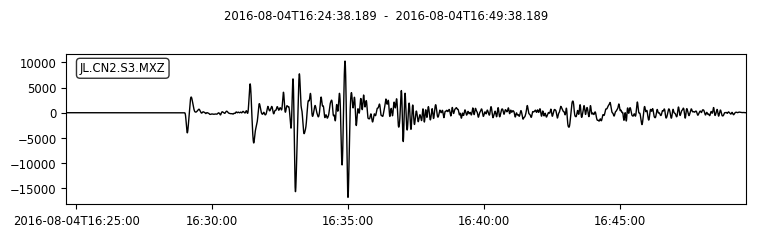

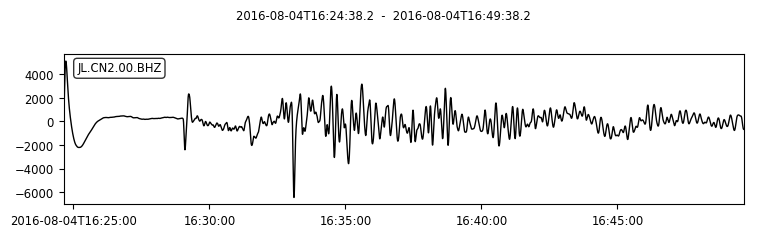

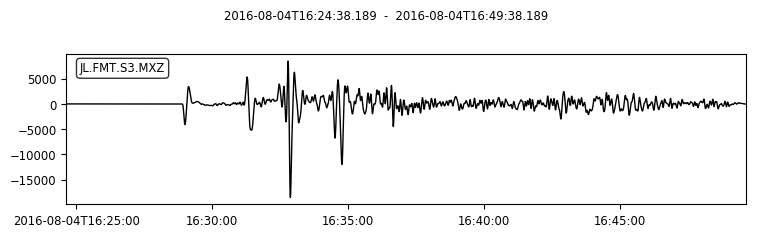

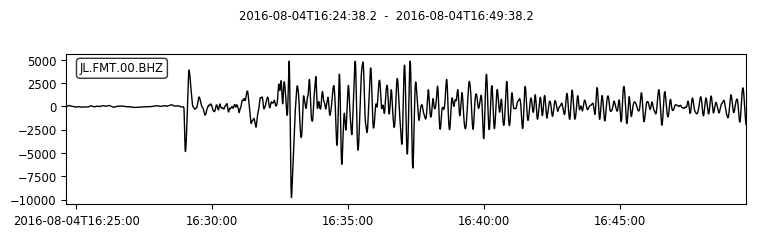

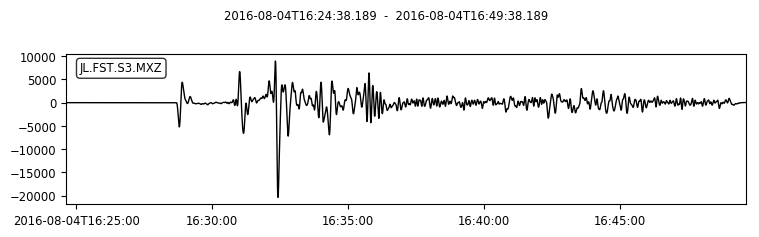

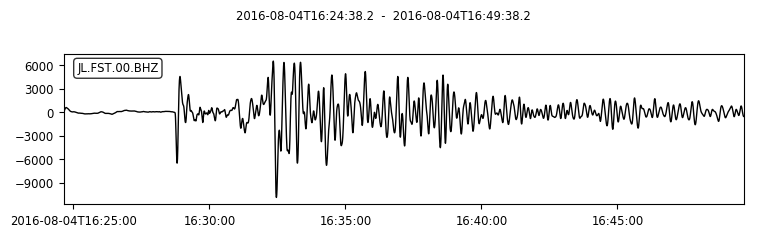

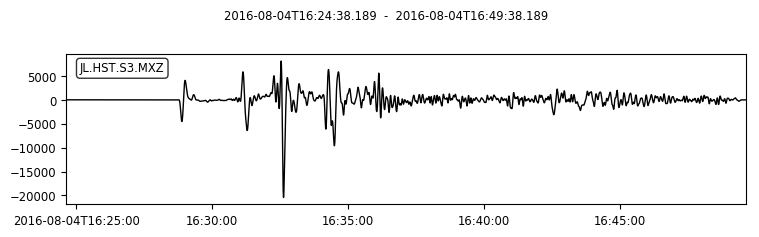

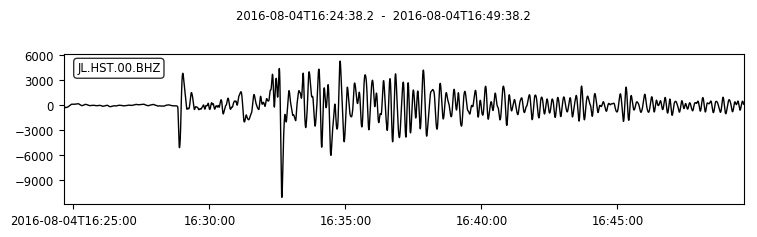

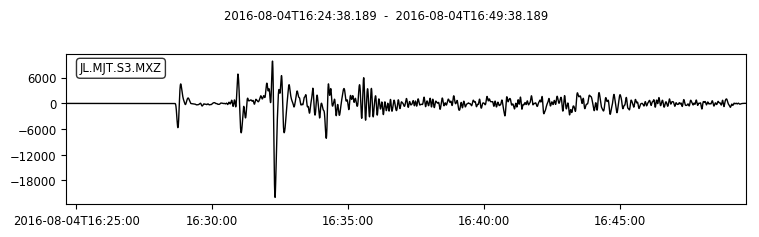

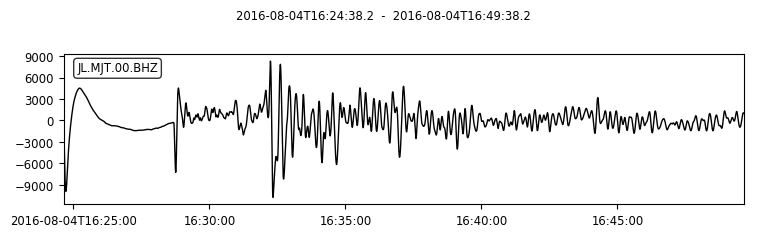

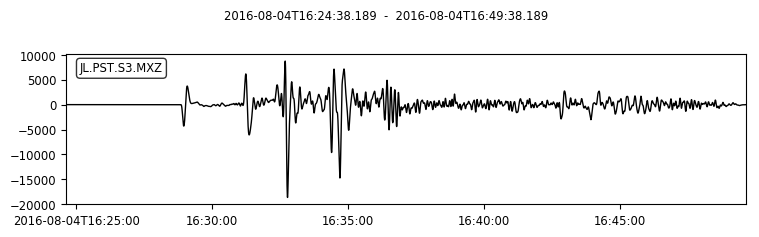

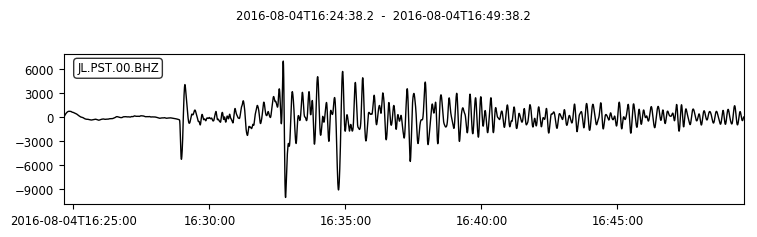

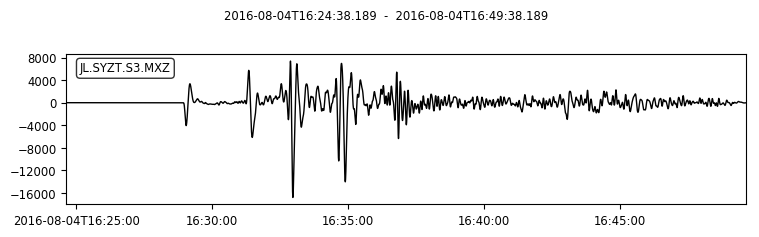

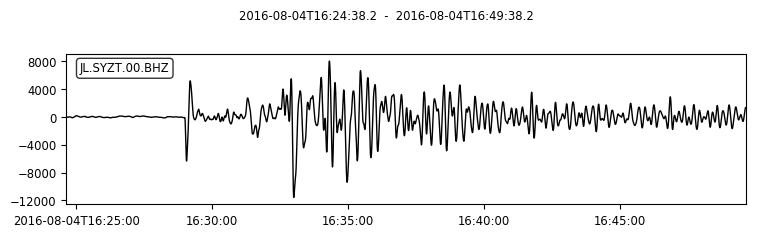

2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
7 Trace(s) in Stream:
JL.CN2.S3.MXR  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
JL.FMT.S3.MXR  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
JL.FST.S3.MXR  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
JL.HST.S3.MXR  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
JL.MJT.S3.MXR  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
JL.PST.S3.MXR  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 

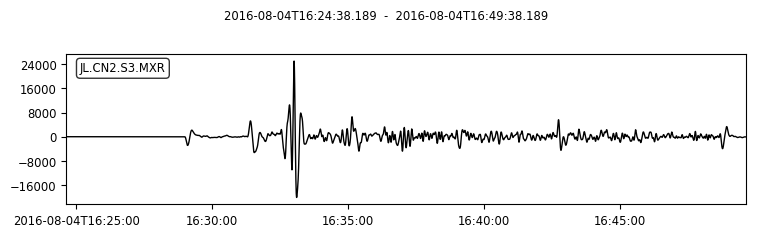

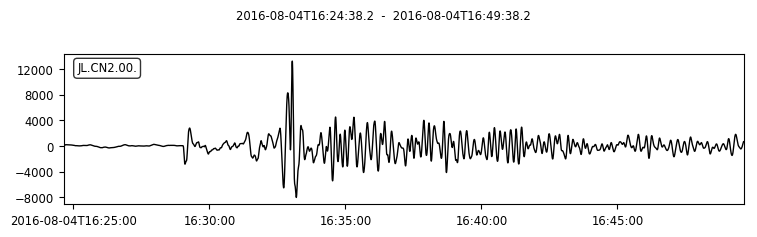

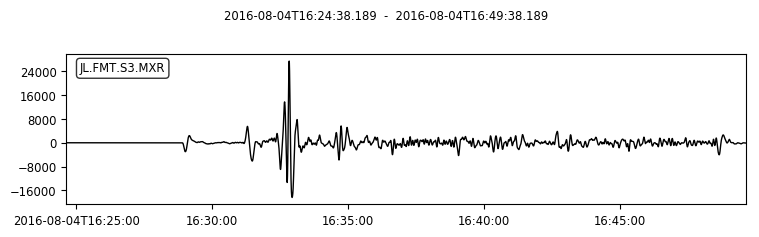

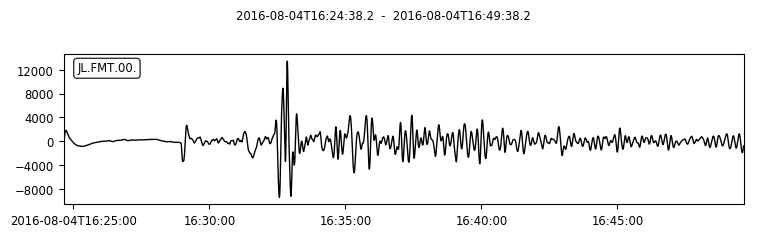

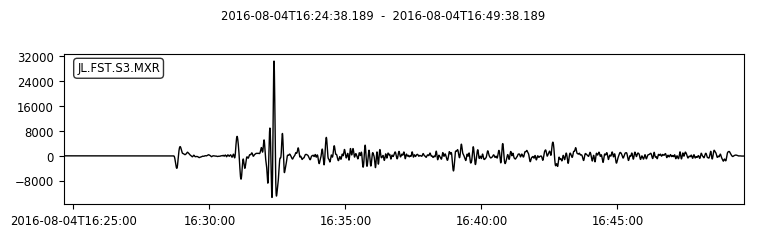

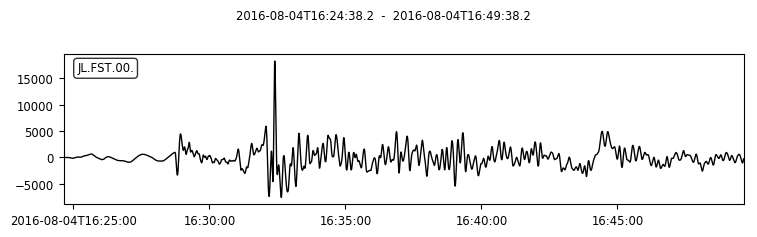

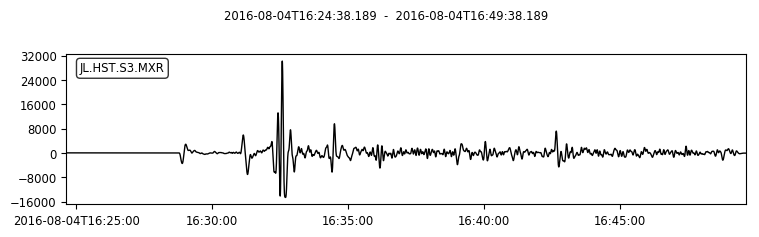

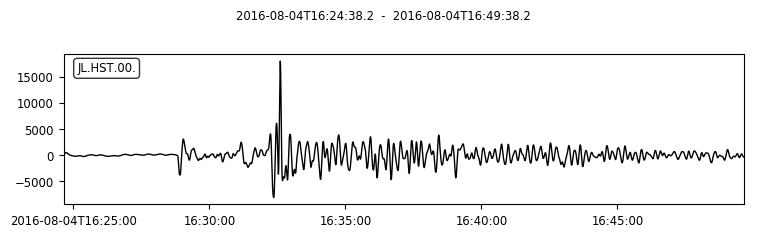

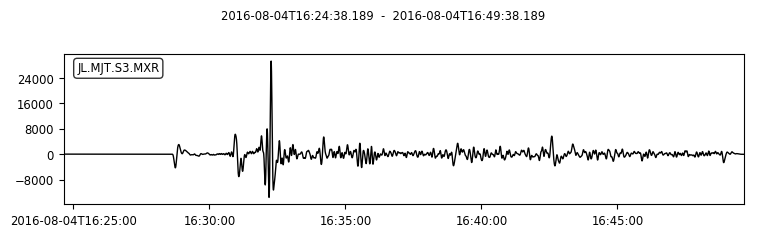

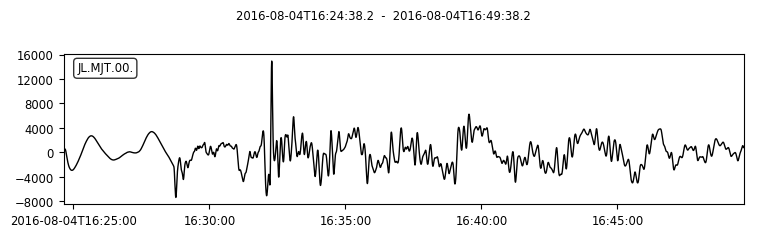

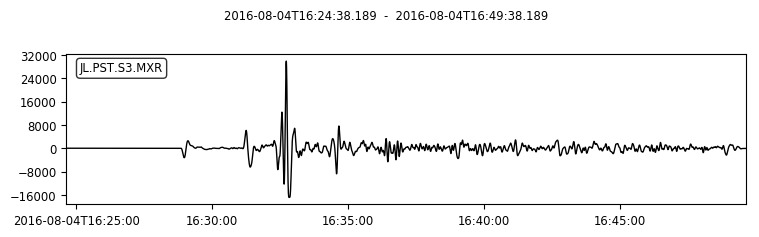

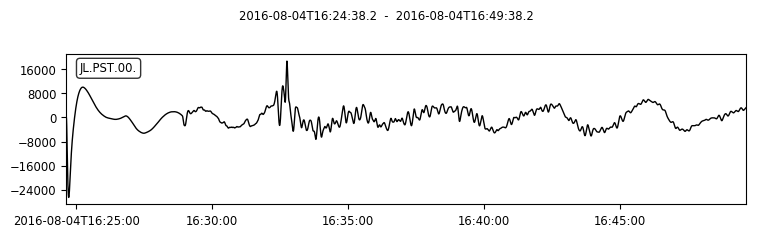

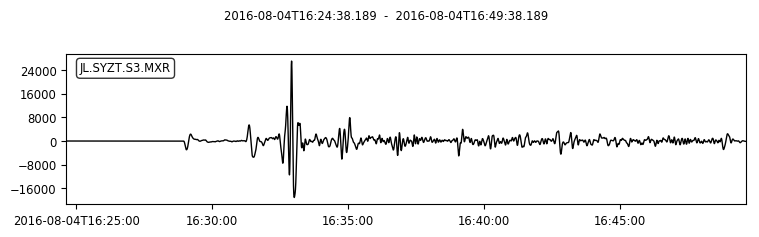

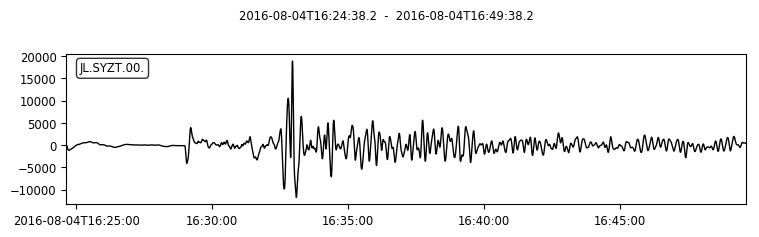

2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
7 Trace(s) in Stream:
JL.CN2.S3.MXT  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
JL.FMT.S3.MXT  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
JL.FST.S3.MXT  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
JL.HST.S3.MXT  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
JL.MJT.S3.MXT  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 30001 samples
JL.PST.S3.MXT  | 2016-08-04T16:24:38.189000Z - 2016-08-04T16:49:38.189000Z | 20.0 Hz, 

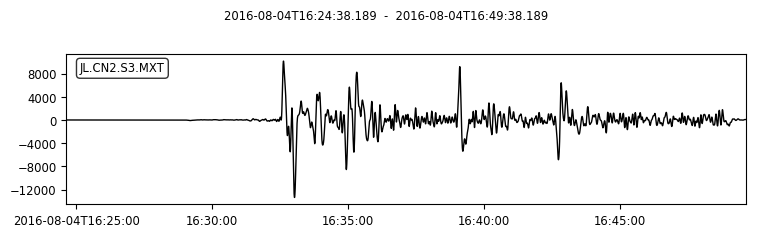

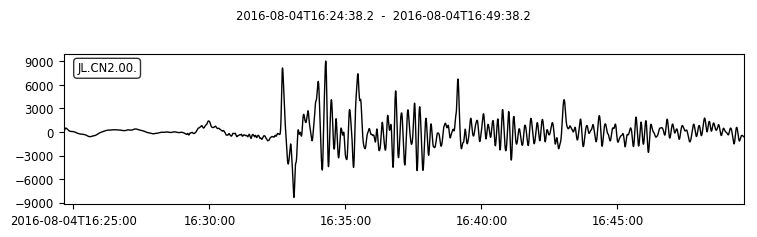

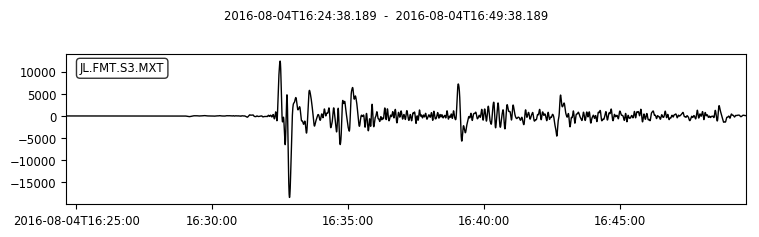

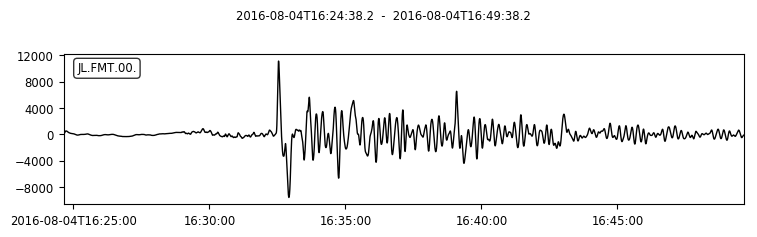

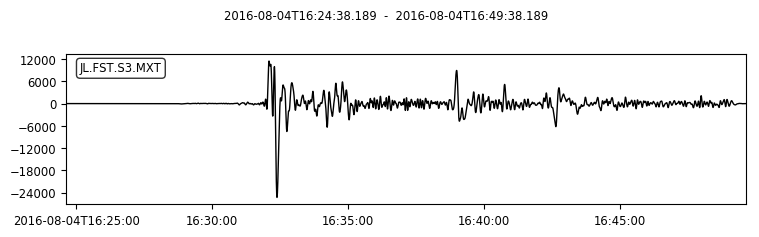

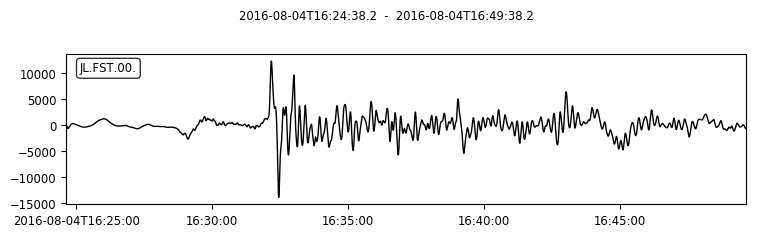

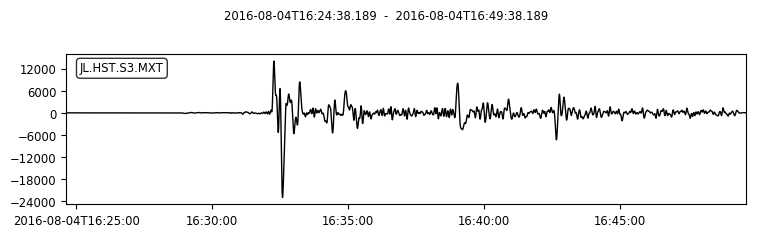

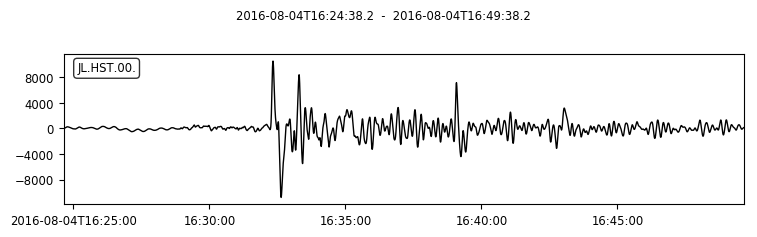

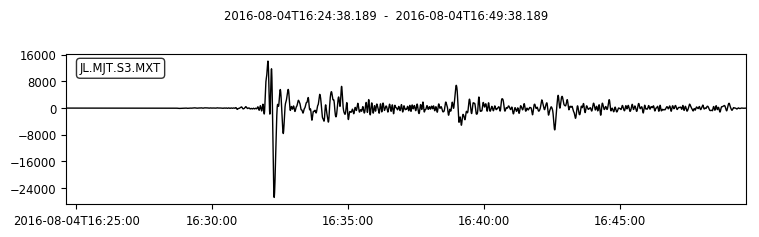

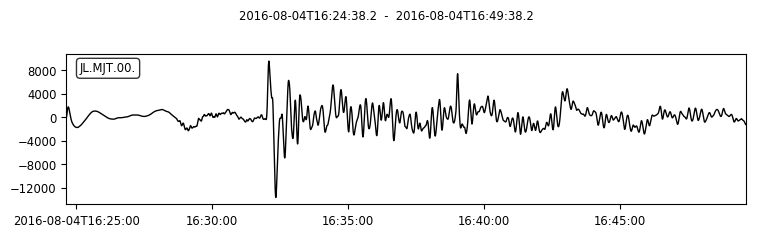

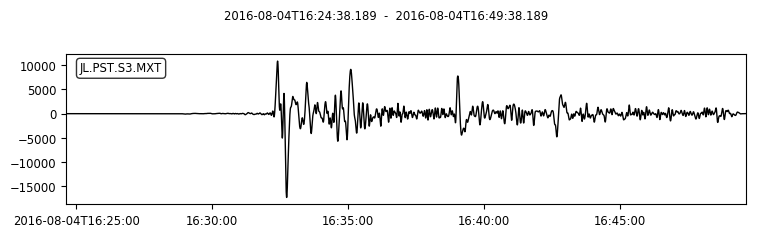

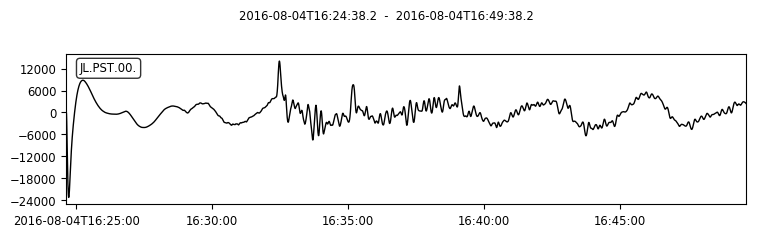

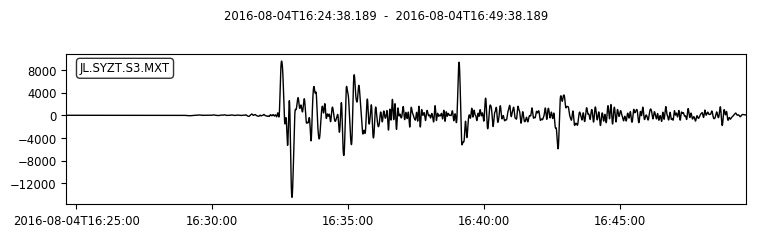

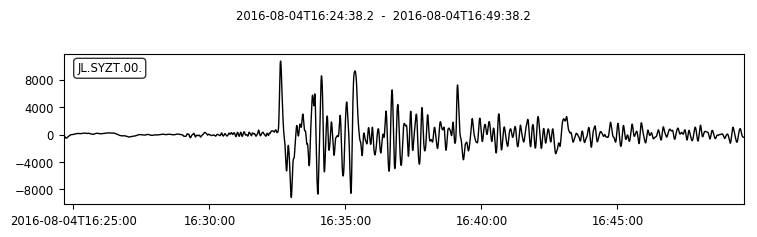

(7 Trace(s) in Stream:
JL.CN2.S3.MXT  | 2016-08-04T16:31:47.139000Z - 2016-08-04T16:33:47.139000Z | 20.0 Hz, 2401 samples
JL.FMT.S3.MXT  | 2016-08-04T16:31:37.439000Z - 2016-08-04T16:33:37.439000Z | 20.0 Hz, 2401 samples
JL.FST.S3.MXT  | 2016-08-04T16:31:14.189000Z - 2016-08-04T16:33:14.189000Z | 20.0 Hz, 2401 samples
JL.HST.S3.MXT  | 2016-08-04T16:31:24.439000Z - 2016-08-04T16:33:24.439000Z | 20.0 Hz, 2401 samples
JL.MJT.S3.MXT  | 2016-08-04T16:31:08.789000Z - 2016-08-04T16:33:08.789000Z | 20.0 Hz, 2401 samples
JL.PST.S3.MXT  | 2016-08-04T16:31:32.339000Z - 2016-08-04T16:33:32.339000Z | 20.0 Hz, 2401 samples
JL.SYZT.S3.MXT | 2016-08-04T16:31:42.389000Z - 2016-08-04T16:33:42.389000Z | 20.0 Hz, 2401 samples,
 7 Trace(s) in Stream:
JL.CN2.00.  | 2016-08-04T16:31:47.170000Z - 2016-08-04T16:33:47.170000Z | 100.0 Hz, 12001 samples
JL.FMT.00.  | 2016-08-04T16:31:37.430000Z - 2016-08-04T16:33:37.430000Z | 100.0 Hz, 12001 samples
JL.FST.00.  | 2016-08-04T16:31:14.210000Z - 2016-08-04T16:33:14.

In [72]:
names=["CN2","FMT","FST","HST","MJT","PST","SYZT"] # ,"MZL" "HLR", "CHR", ,"IDR"
syncz=get_sync_cea("/Users/ziyixi/Datas/fnet/cea/sync",names,"Z")
dataz=get_data_cea("/Users/ziyixi/Datas/fnet/cea/poster",names,"Z")
syncr=get_sync_cea("/Users/ziyixi/Datas/fnet/cea/sync",names,"R")
datar=get_data_cea("/Users/ziyixi/Datas/fnet/cea/poster",names,"R")
synct=get_sync_cea("/Users/ziyixi/Datas/fnet/cea/sync",names,"T")
datat=get_data_cea("/Users/ziyixi/Datas/fnet/cea/poster",names,"T")
preprocess(syncz,dataz,1/100,1/10,"s",-50,70)
preprocess(syncr,datar,1/100,1/10,"s",-50,70)
preprocess(synct,datat,1/100,1/10,"s",-50,70)

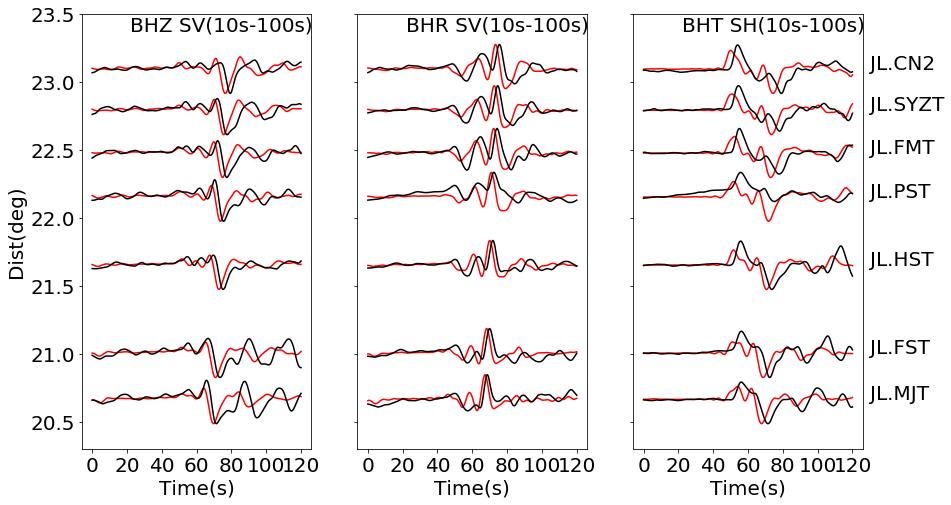

In [73]:
plot_three_component_cea(dataz,datar,datat,syncz,syncr,synct,-50,70,0.18)

2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.

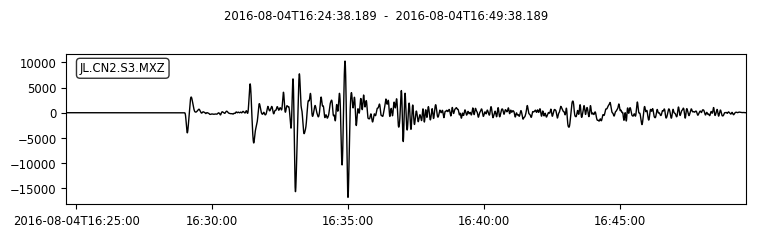

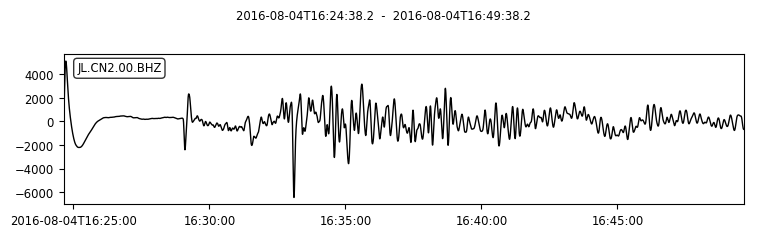

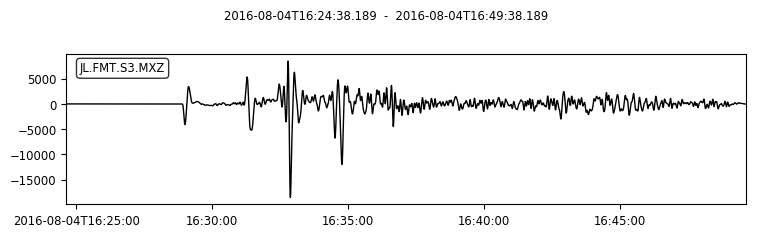

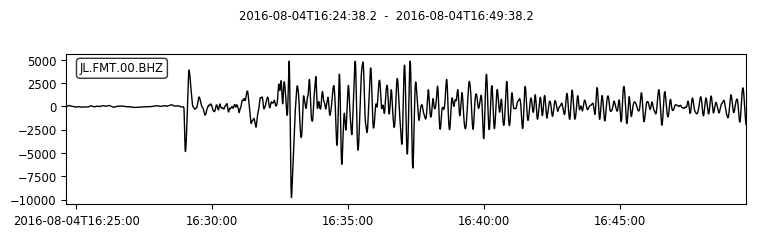

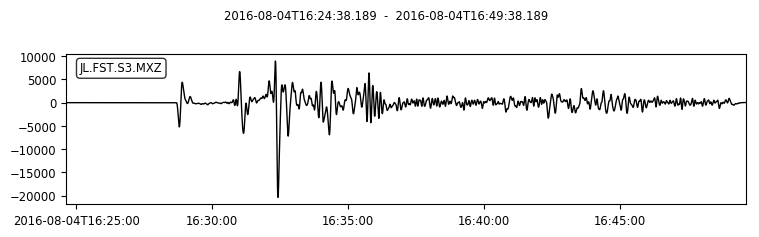

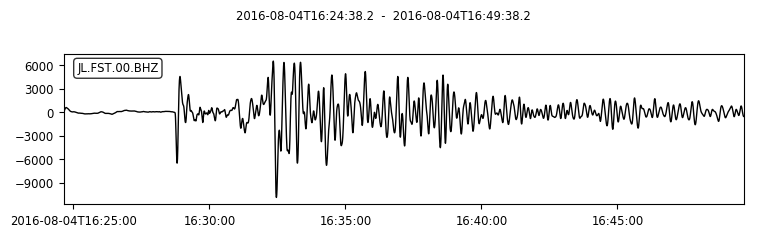

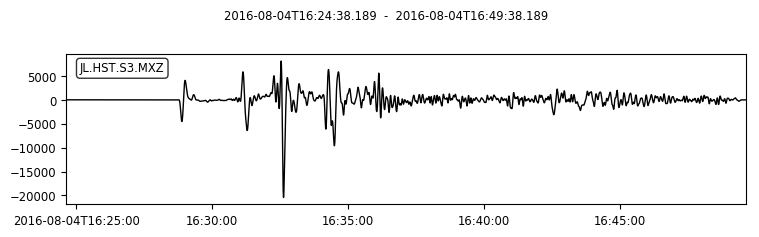

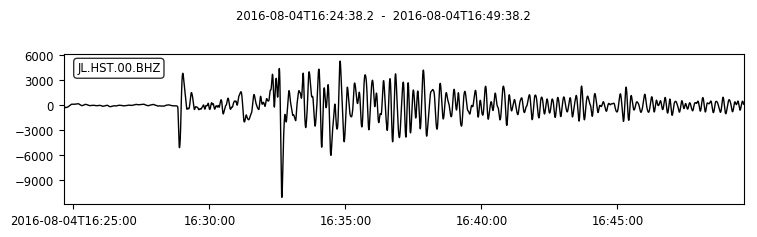

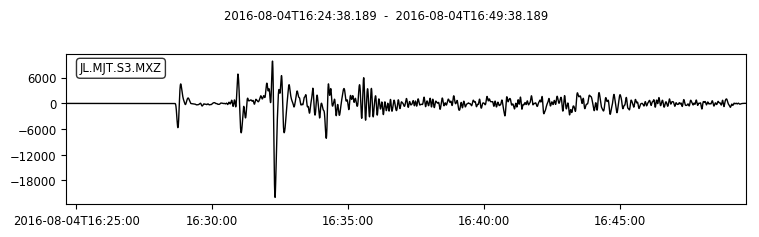

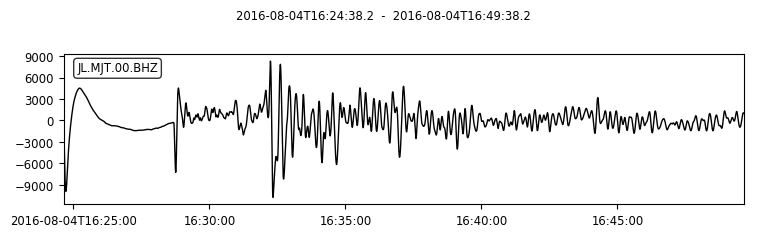

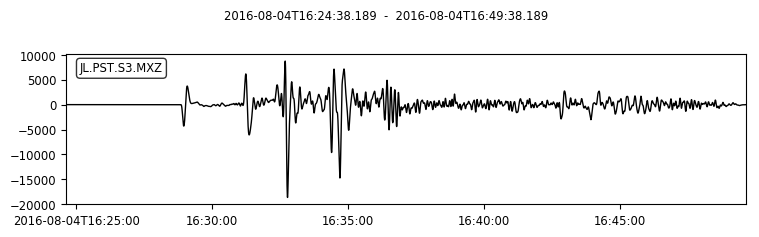

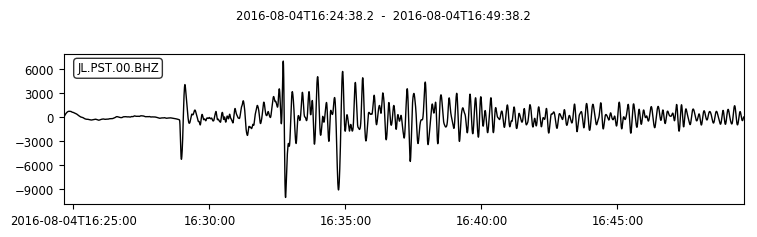

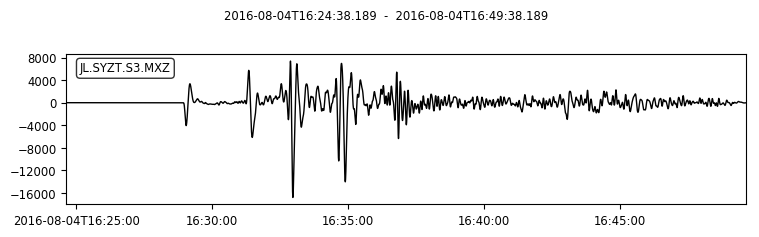

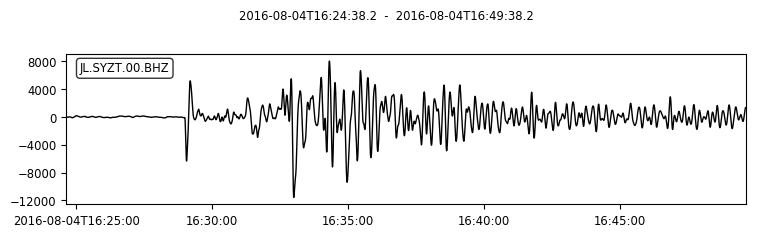

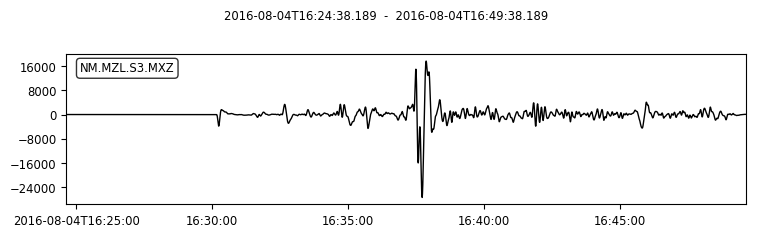

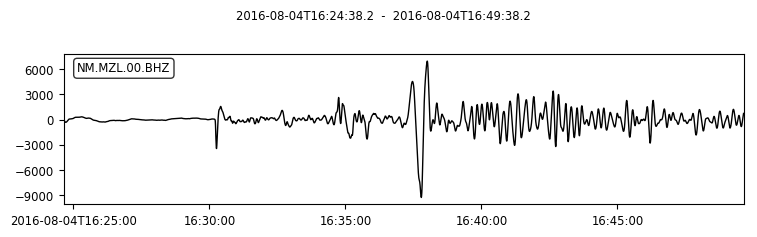

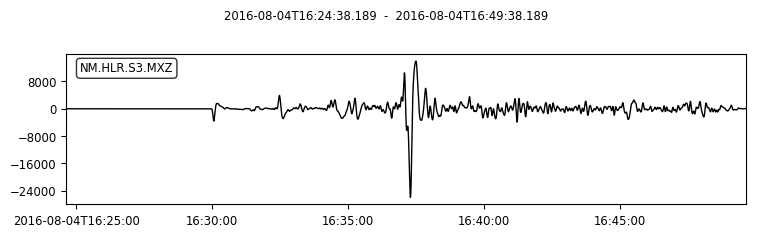

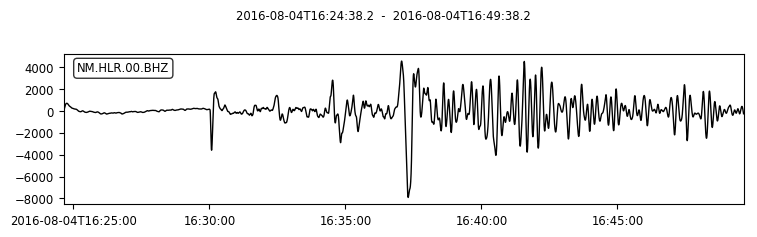

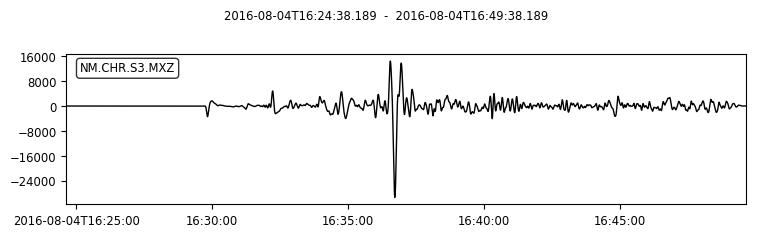

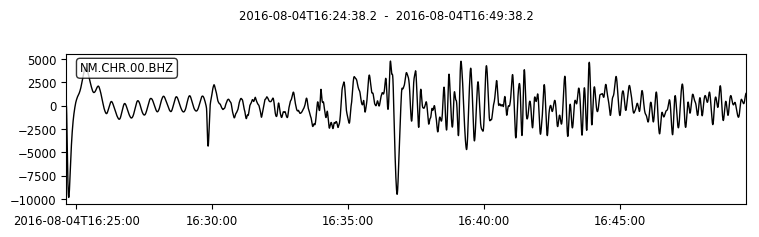

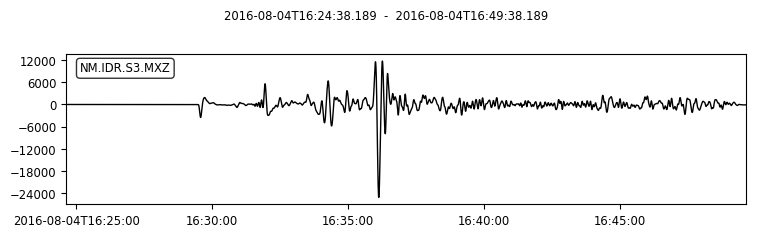

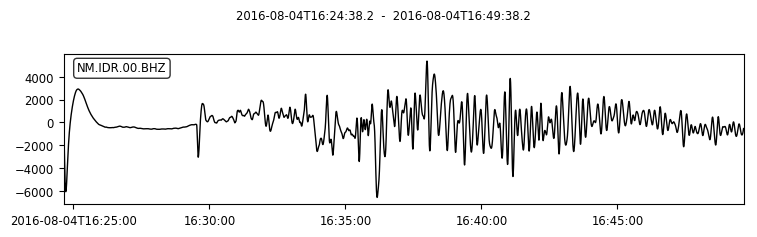

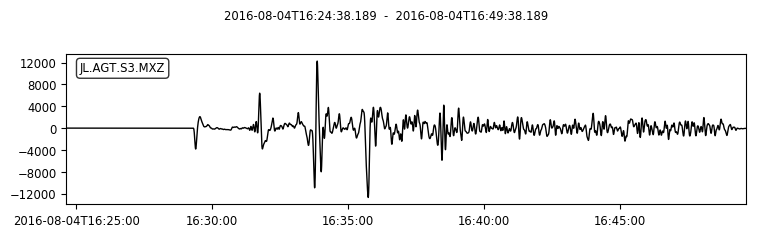

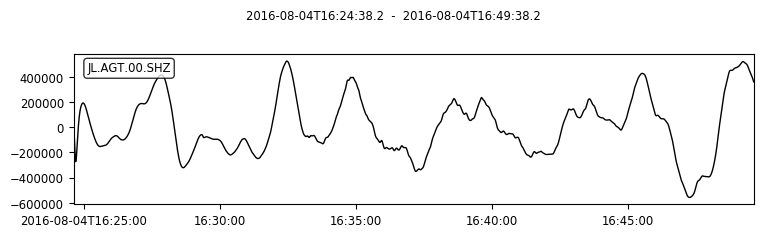

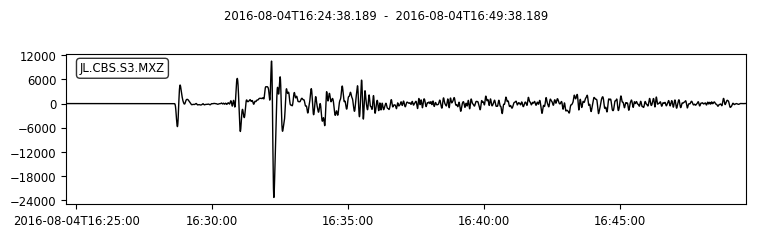

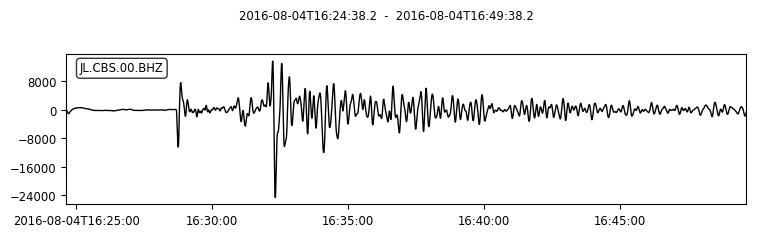

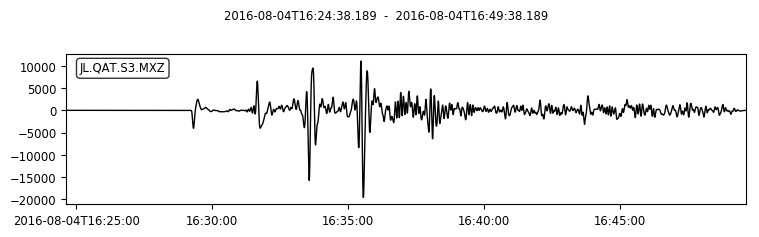

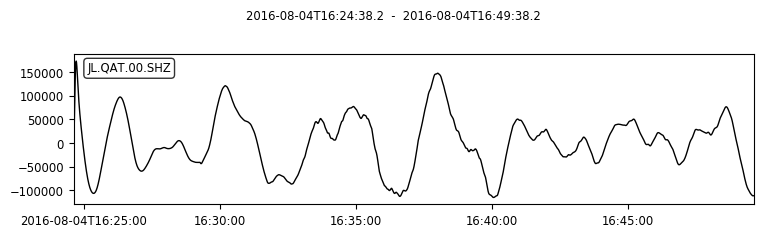

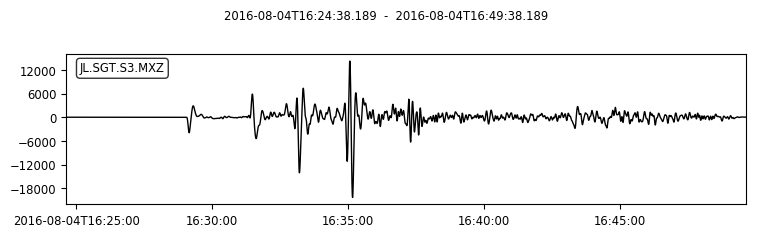

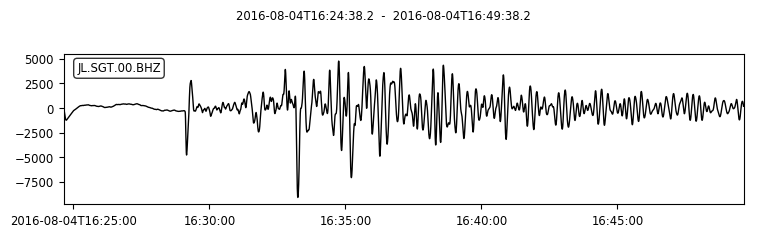

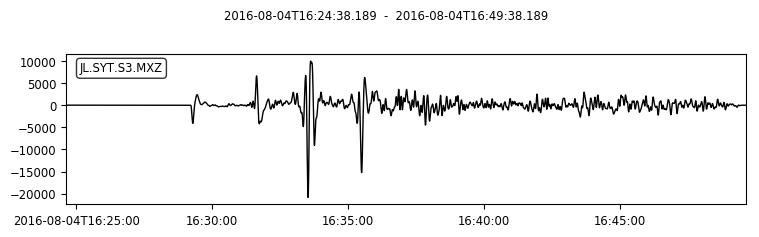

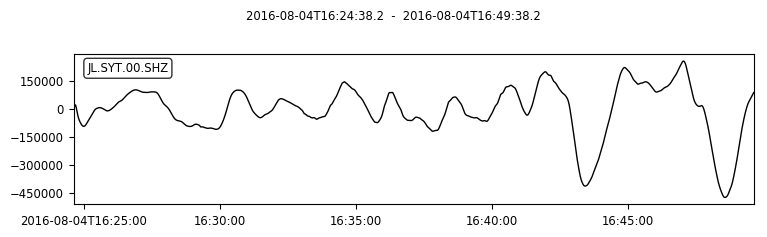

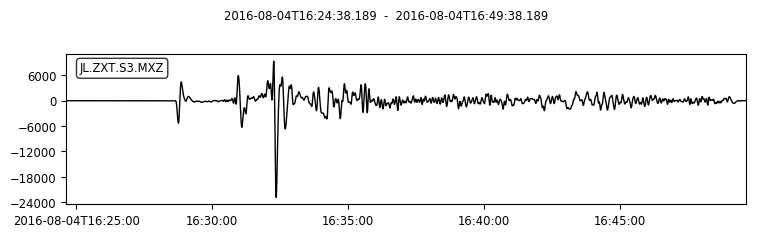

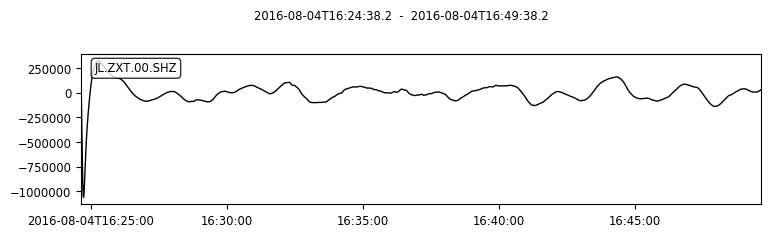

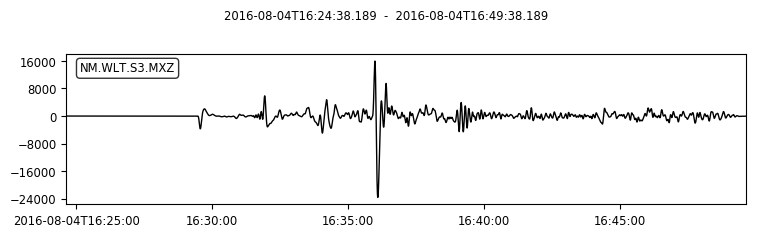

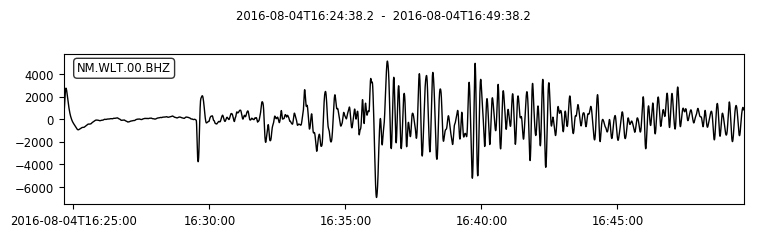

2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.

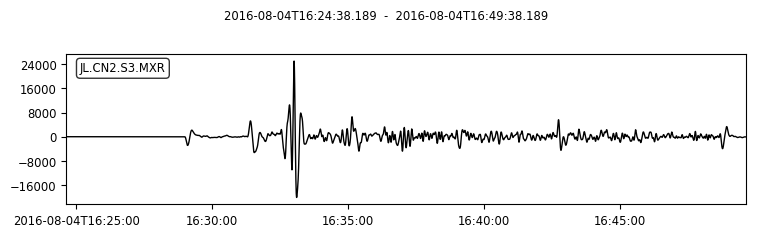

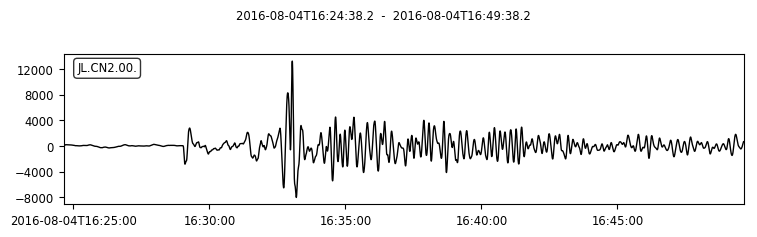

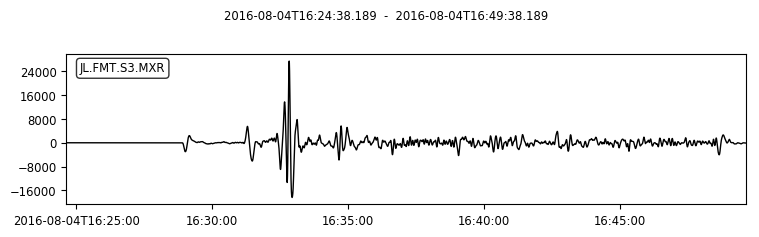

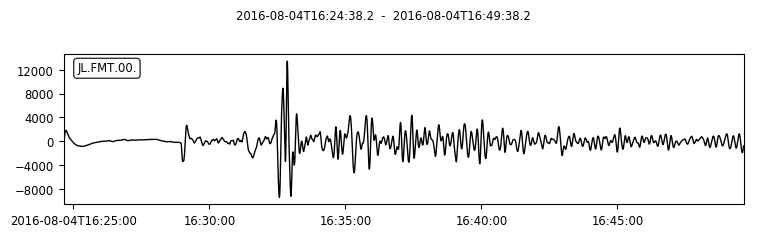

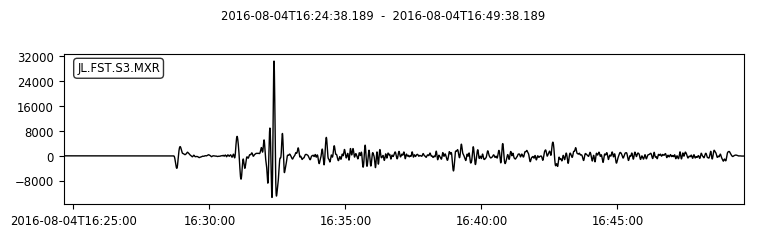

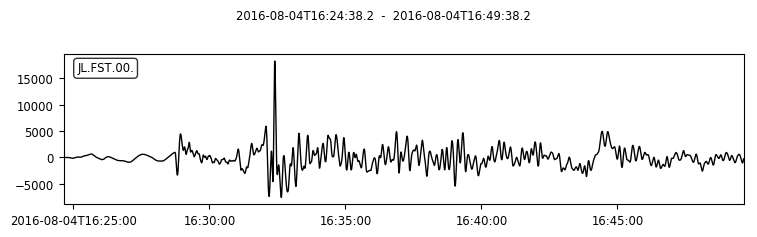

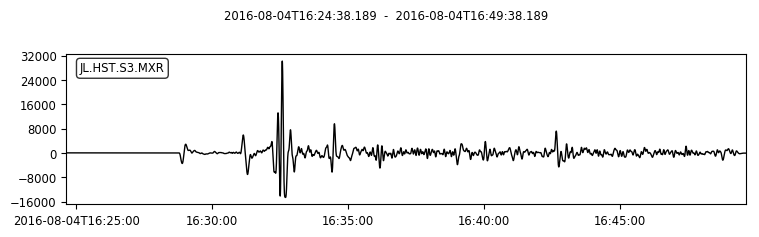

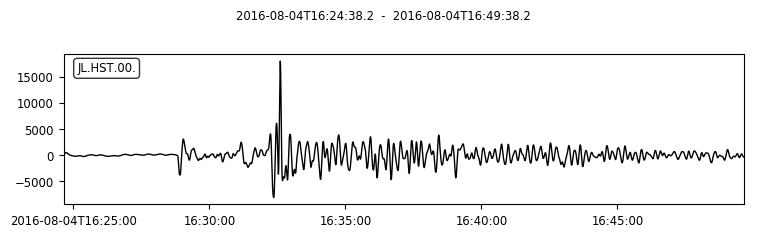

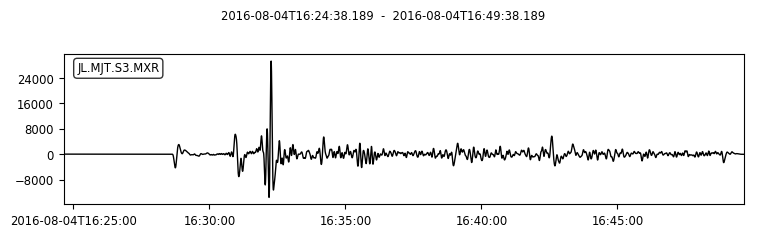

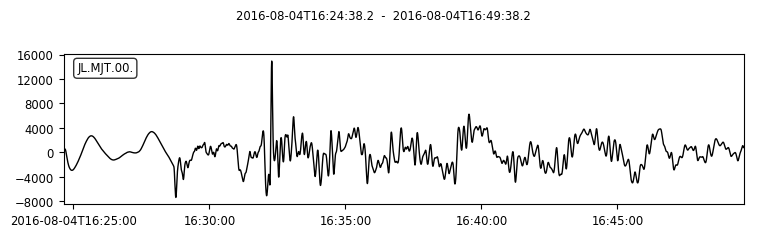

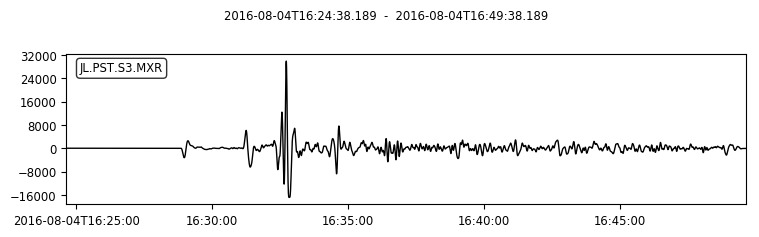

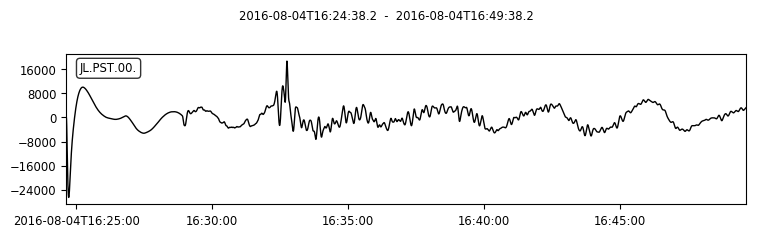

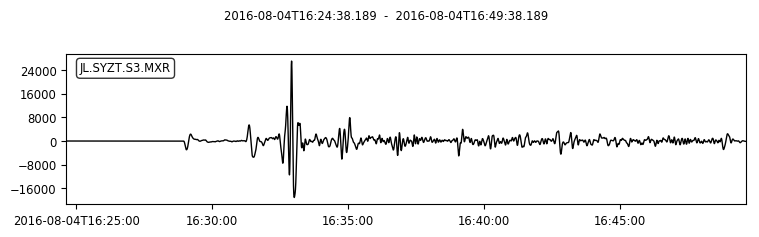

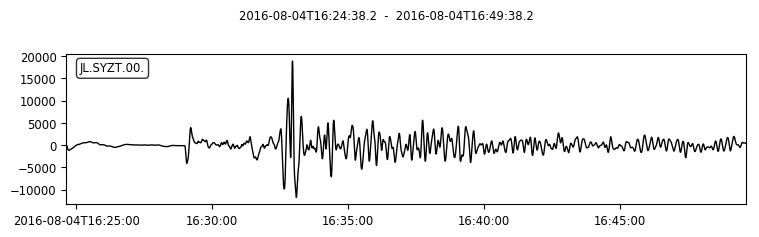

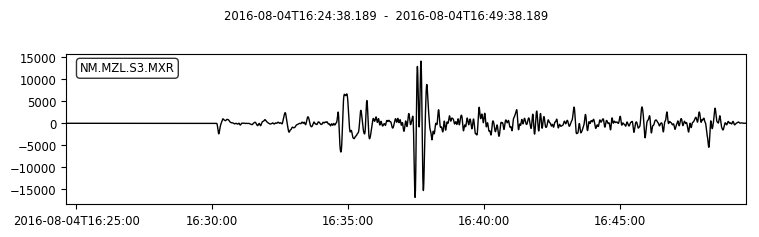

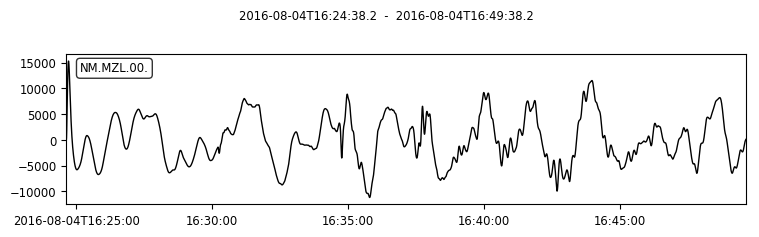

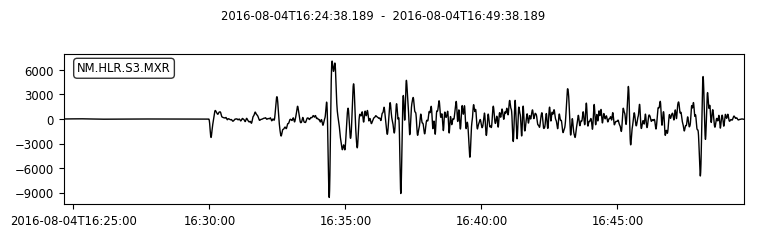

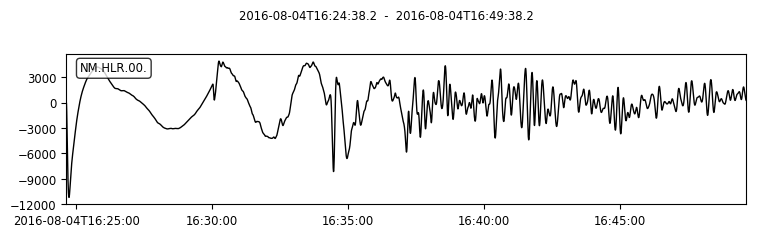

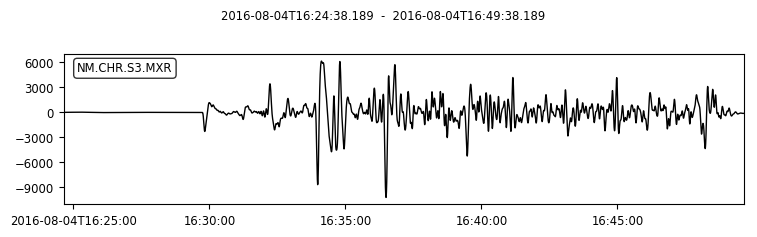

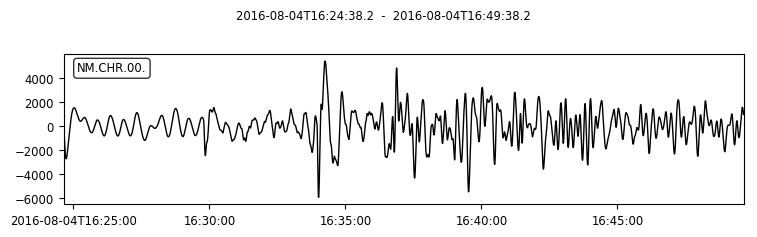

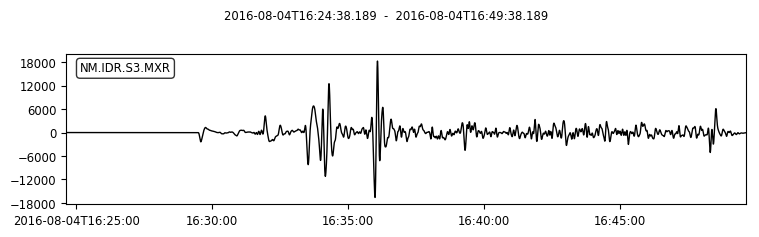

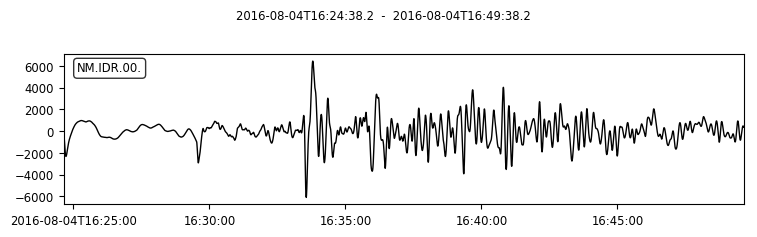

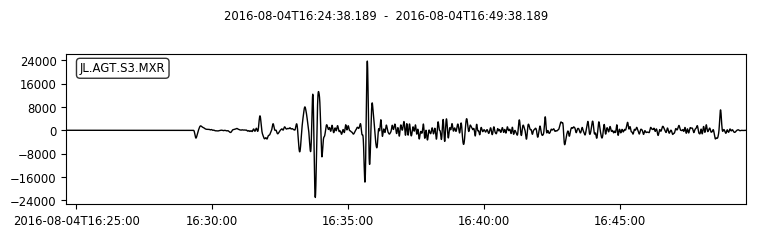

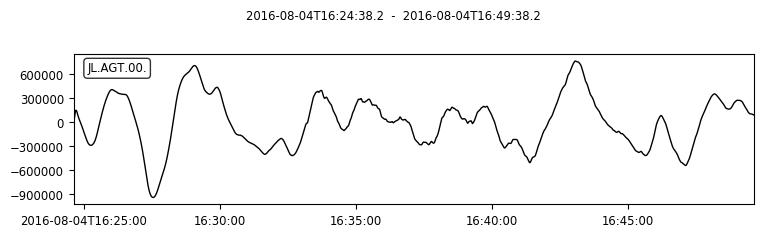

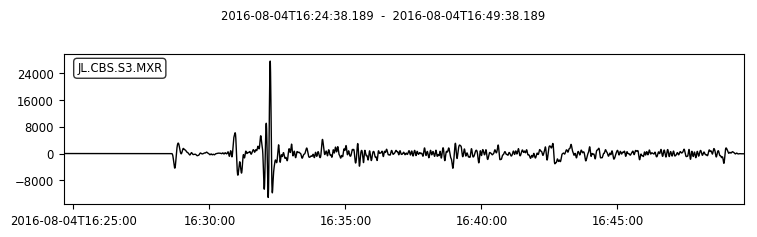

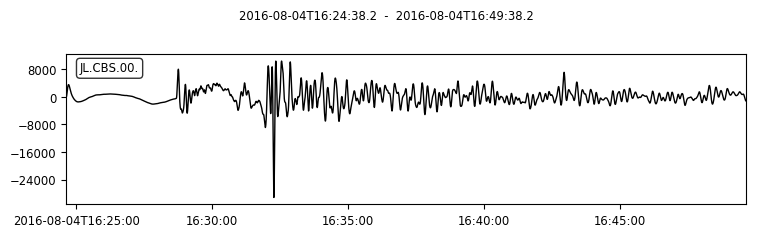

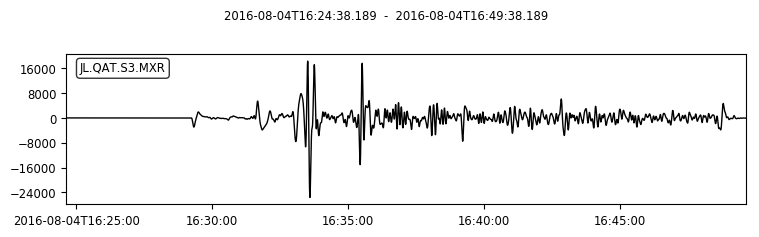

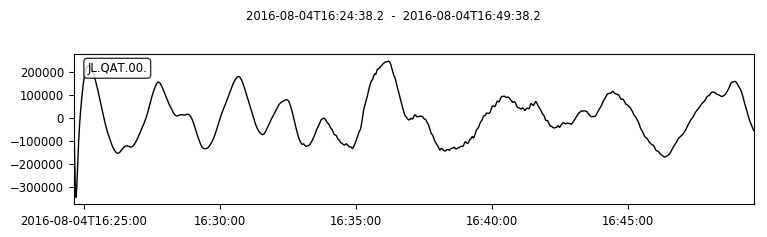

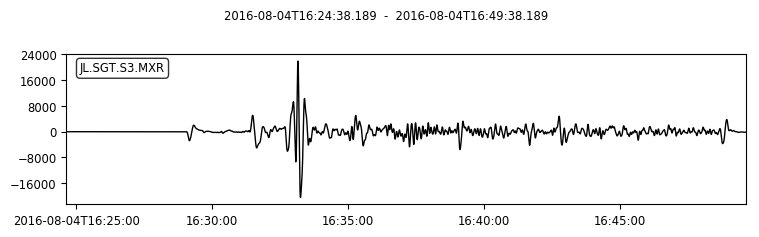

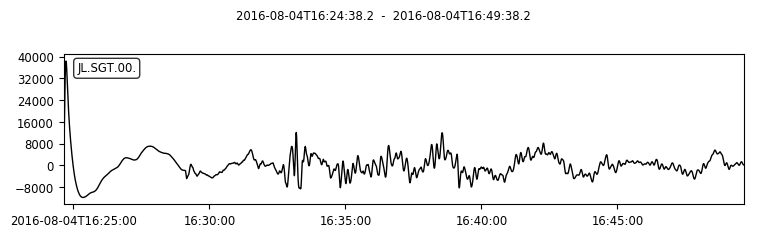

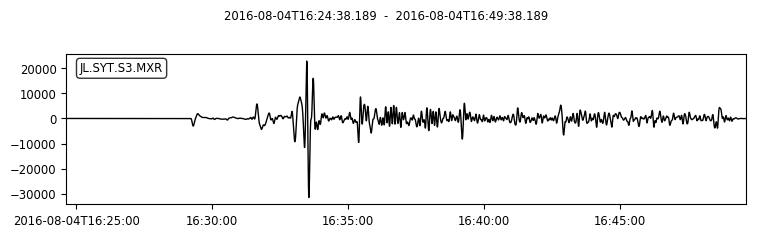

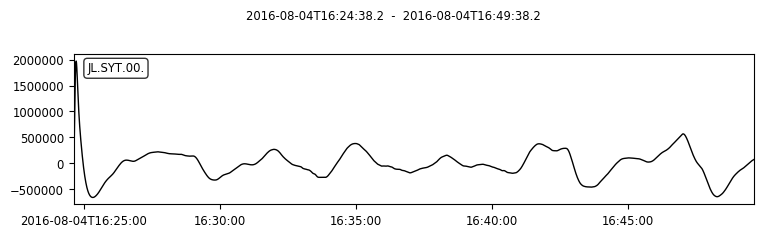

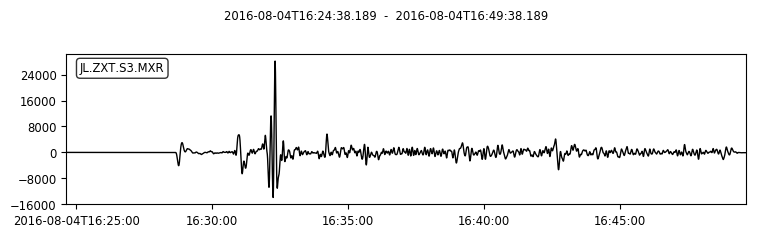

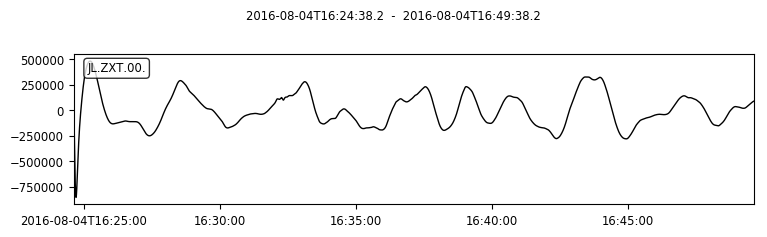

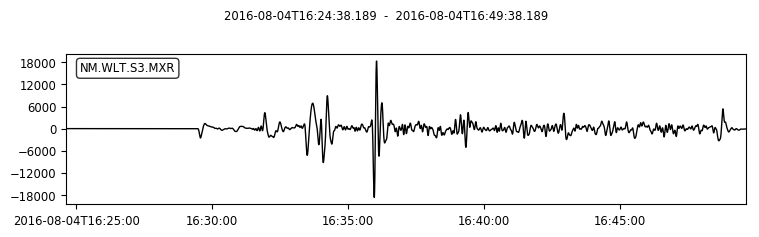

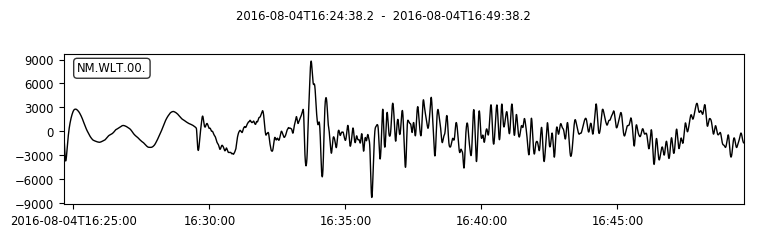

2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.200000Z
2016-08-04T16:24:38.189000Z
2016-08-04T16:24:38.

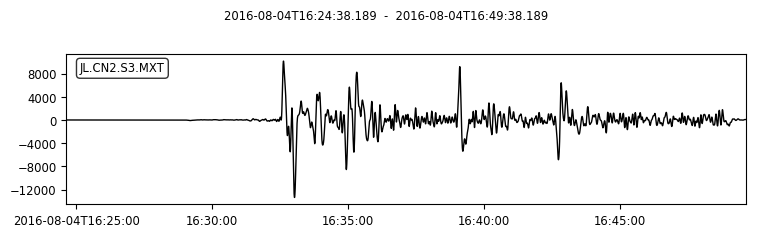

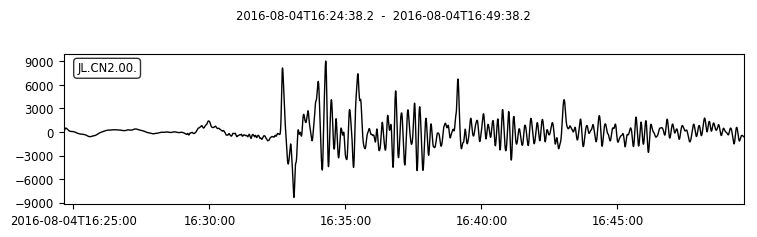

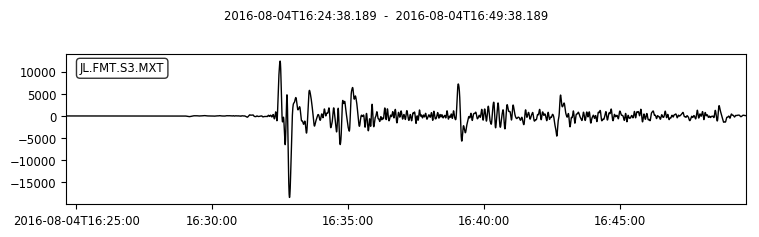

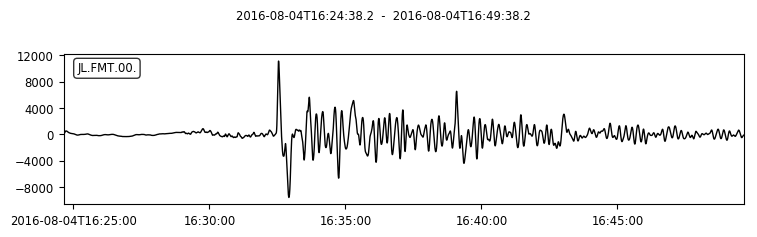

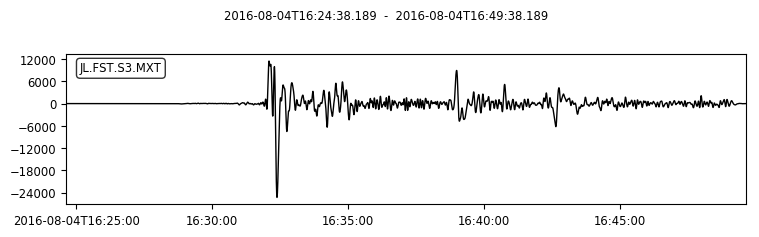

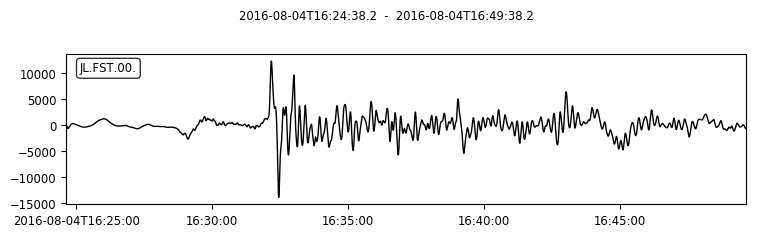

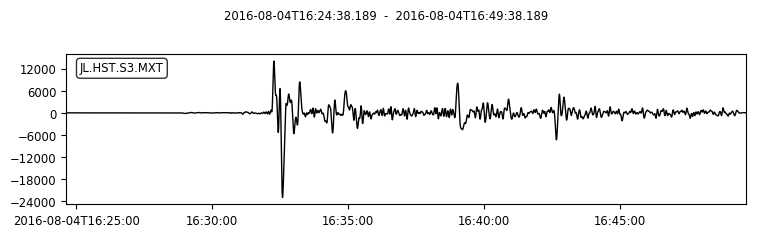

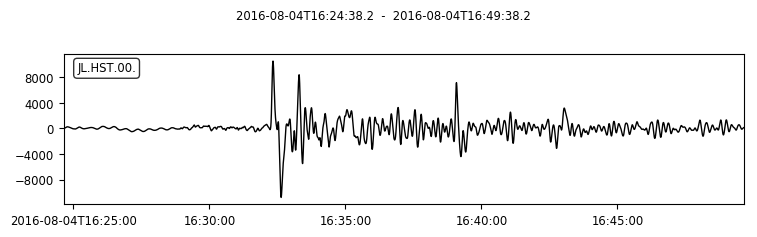

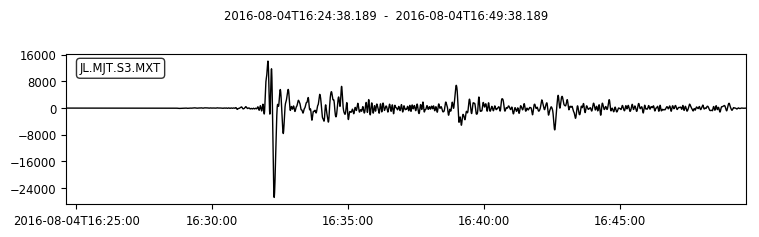

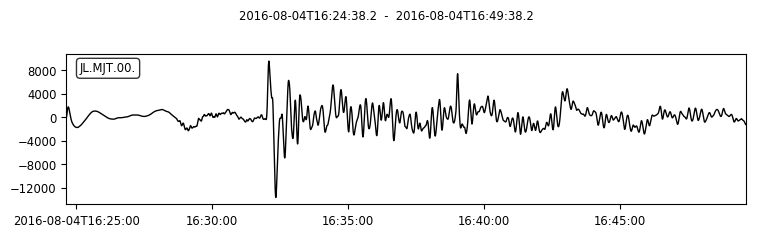

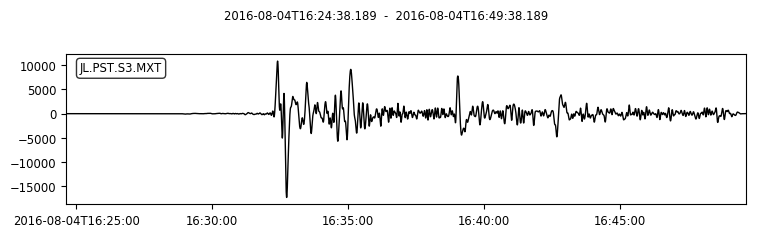

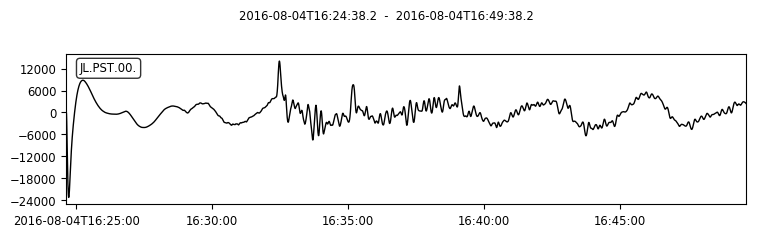

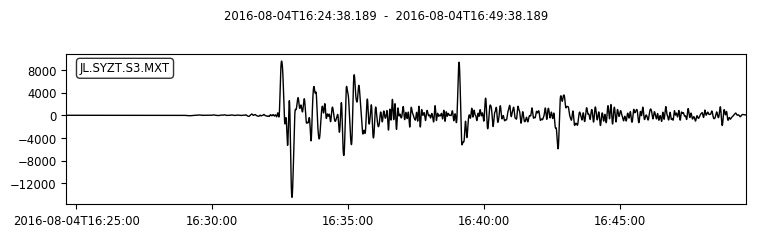

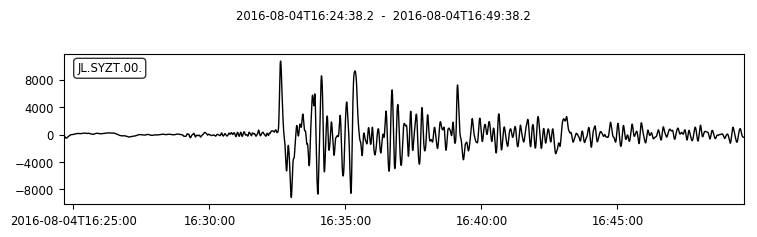

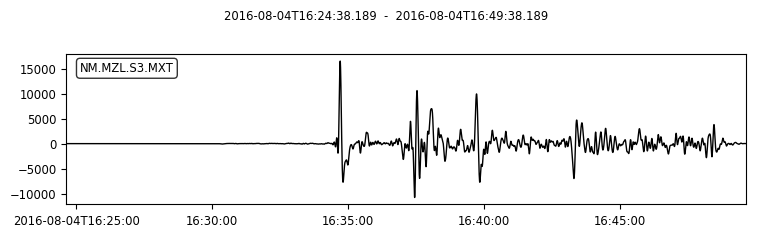

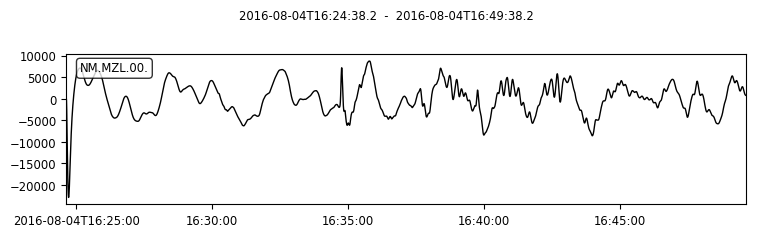

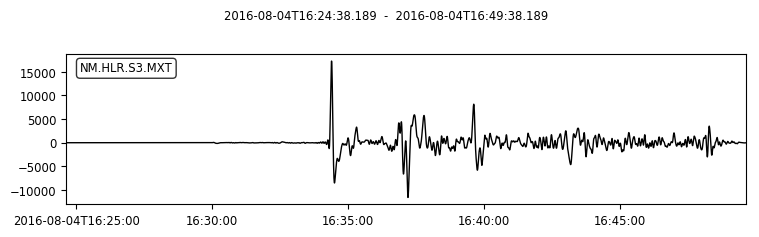

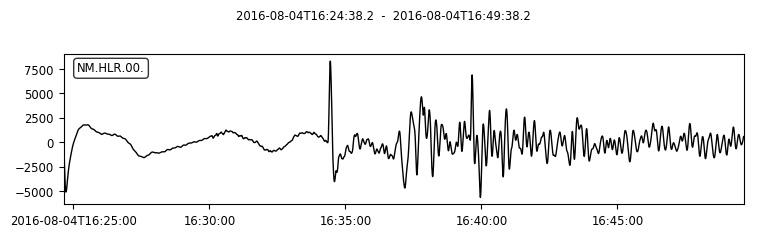

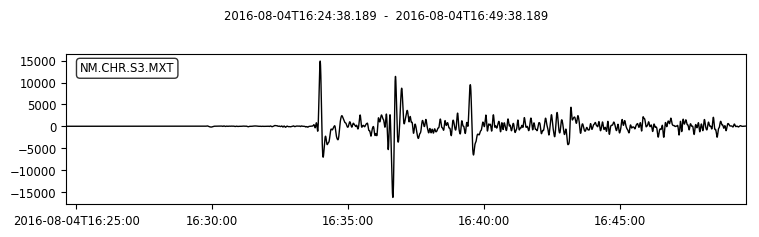

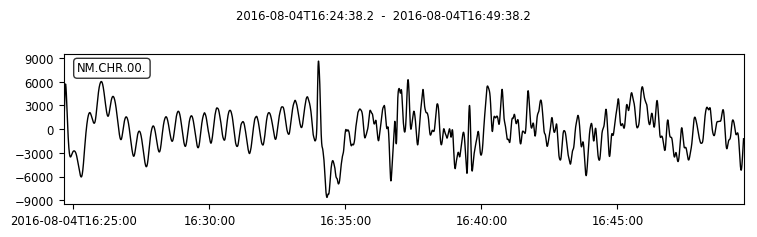

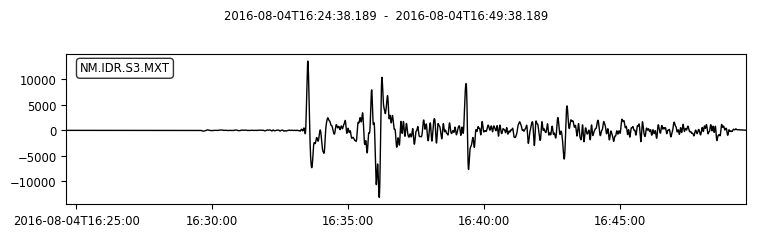

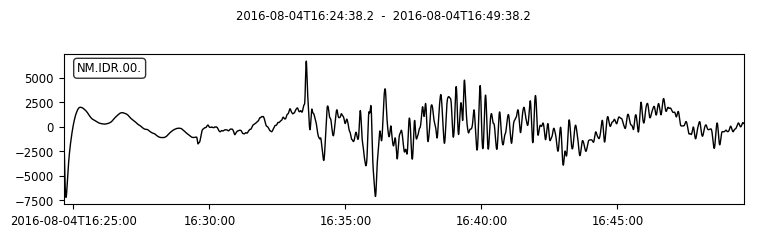

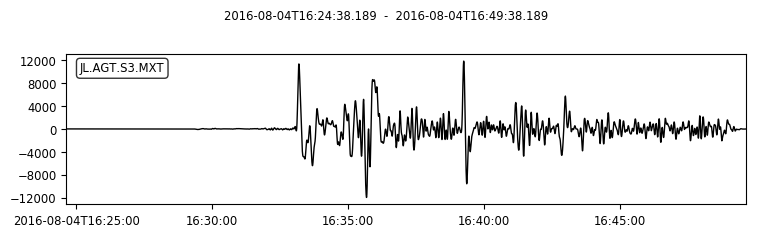

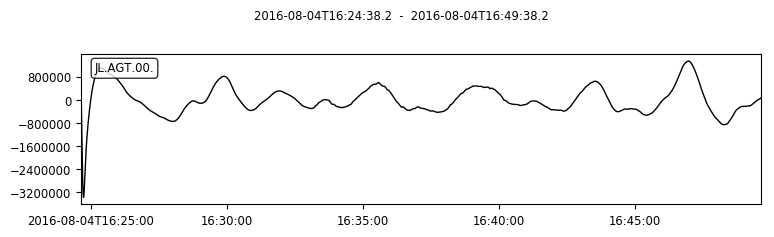

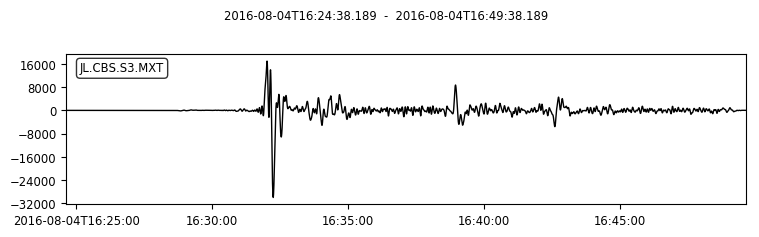

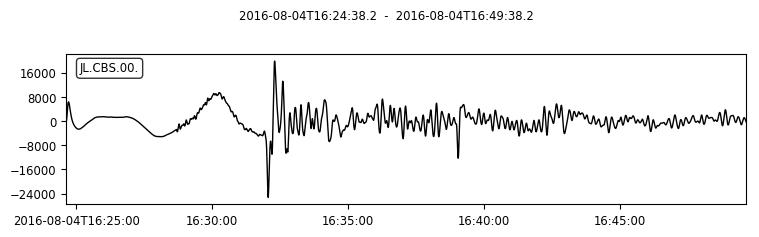

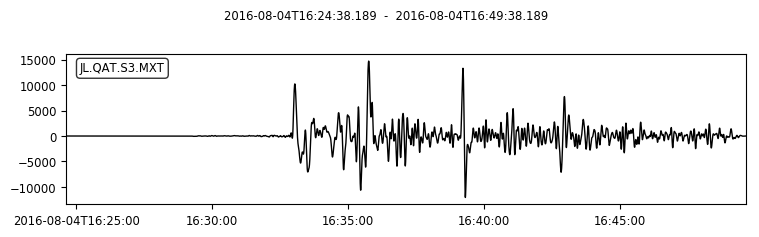

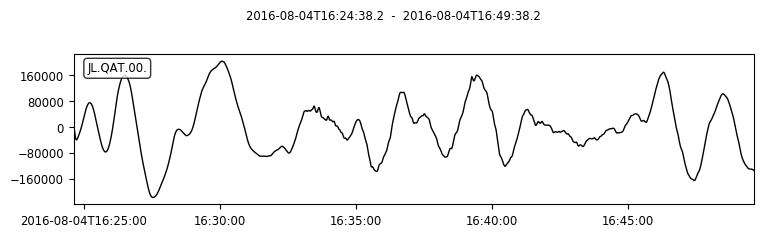

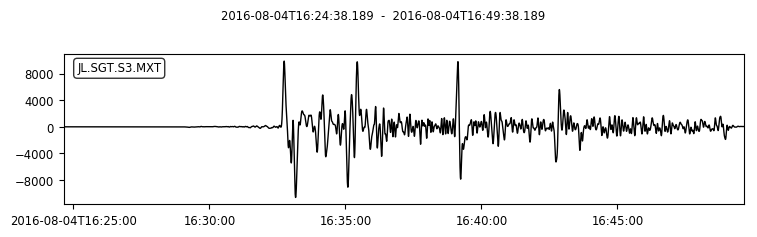

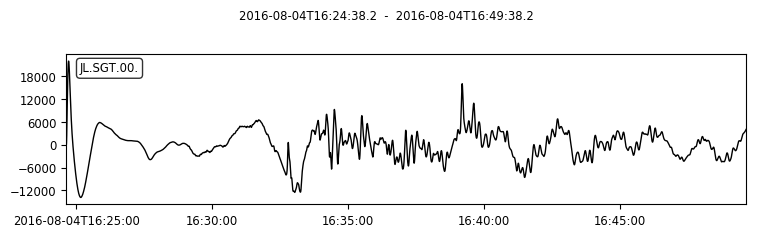

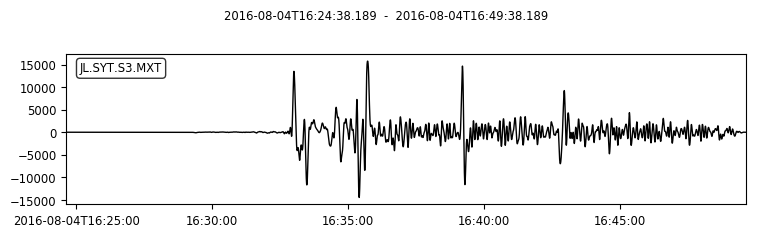

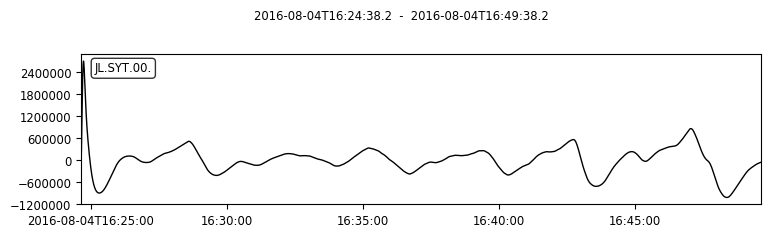

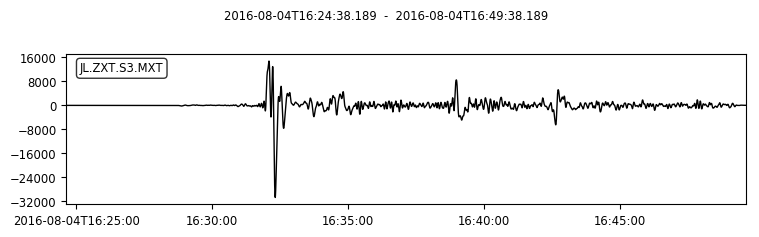

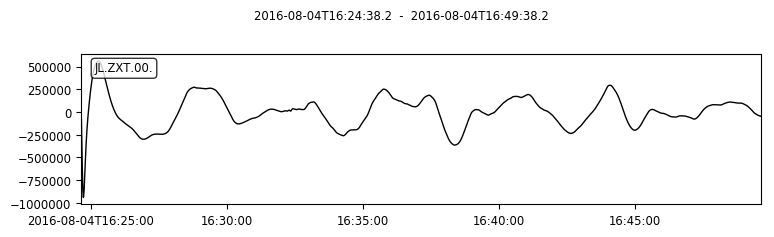

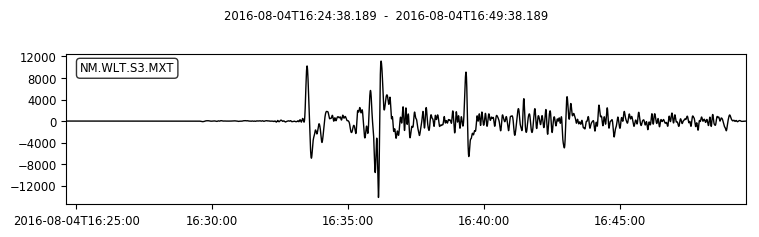

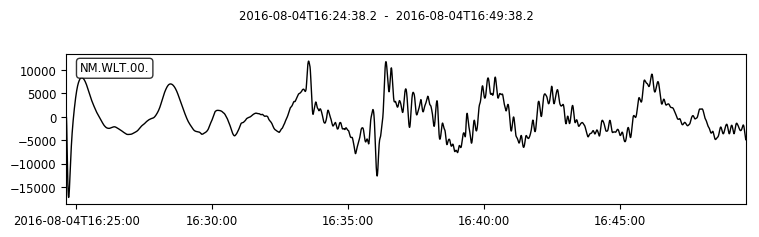

(18 Trace(s) in Stream:
JL.CN2.S3.MXT  | 2016-08-04T16:31:47.139000Z - 2016-08-04T16:33:47.139000Z | 20.0 Hz, 2401 samples
JL.FMT.S3.MXT  | 2016-08-04T16:31:37.439000Z - 2016-08-04T16:33:37.439000Z | 20.0 Hz, 2401 samples
JL.FST.S3.MXT  | 2016-08-04T16:31:14.189000Z - 2016-08-04T16:33:14.189000Z | 20.0 Hz, 2401 samples
JL.HST.S3.MXT  | 2016-08-04T16:31:24.439000Z - 2016-08-04T16:33:24.439000Z | 20.0 Hz, 2401 samples
JL.MJT.S3.MXT  | 2016-08-04T16:31:08.789000Z - 2016-08-04T16:33:08.789000Z | 20.0 Hz, 2401 samples
JL.PST.S3.MXT  | 2016-08-04T16:31:32.339000Z - 2016-08-04T16:33:32.339000Z | 20.0 Hz, 2401 samples
JL.SYZT.S3.MXT | 2016-08-04T16:31:42.389000Z - 2016-08-04T16:33:42.389000Z | 20.0 Hz, 2401 samples
NM.MZL.S3.MXT  | 2016-08-04T16:33:51.239000Z - 2016-08-04T16:35:51.239000Z | 20.0 Hz, 2401 samples
NM.HLR.S3.MXT  | 2016-08-04T16:33:31.739000Z - 2016-08-04T16:35:31.739000Z | 20.0 Hz, 2401 samples
NM.CHR.S3.MXT  | 2016-08-04T16:33:06.989000Z - 2016-08-04T16:35:06.989000Z | 20.0 Hz,

In [74]:
names=["CN2","FMT","FST","HST","MJT","PST","SYZT","MZL" ,"HLR", "CHR", "IDR","AGT","CBS","QAT","SGT","SYT","ZXT","WLT"] # ,
syncz=get_sync_cea("/Users/ziyixi/Datas/fnet/cea/sync",names,"Z")
dataz=get_data_cea("/Users/ziyixi/Datas/fnet/cea/poster",names,"Z")
syncr=get_sync_cea("/Users/ziyixi/Datas/fnet/cea/sync",names,"R")
datar=get_data_cea("/Users/ziyixi/Datas/fnet/cea/poster",names,"R")
synct=get_sync_cea("/Users/ziyixi/Datas/fnet/cea/sync",names,"T")
datat=get_data_cea("/Users/ziyixi/Datas/fnet/cea/poster",names,"T")
preprocess(syncz,dataz,1/100,1/10,"s",-50,70)
preprocess(syncr,datar,1/100,1/10,"s",-50,70)
preprocess(synct,datat,1/100,1/10,"s",-50,70)

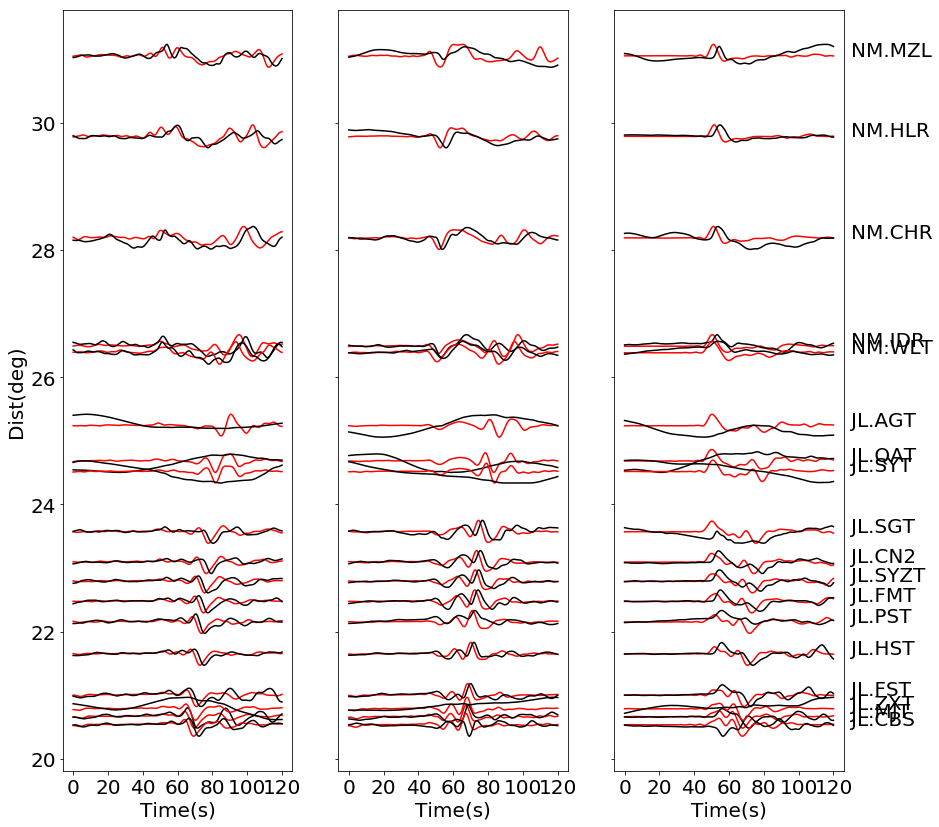

In [83]:
plot_three_component_cea(dataz,datar,datat,syncz,syncr,synct,-50,70,0.18)